# Requirement 4

In [17]:
# Import
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
import random

In [18]:
# utility function
def solve_linear_program(f, ct, rho):
    c = -f
    A_ub = [ct]
    b_ub = [rho]
    A_eq = [np.ones(len(f))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    return res.x, -res.fun

def find_rank(bid, m_t):
    for i in range(len(m_t)):
        if bid >= m_t[i]:
            return i
    return -1


def find_index(winners, i):
    for j in range(len(winners)):
        if winners[j] == i:
            return j
    return -1

## Creating the Auction class

In [19]:
class Auction:
    def __init__(self, click_through_rates, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism
        payments_per_click = self.get_payments_per_click(winners, values, bids) # payment rule
        return winners, payments_per_click
    
    def get_click_through_rates(self):
        return self.click_through_rates


class GeneralizedFirstPriceAuction(Auction):
    def __init__(self, click_through_rates, lambdas):
        self.click_through_rates = click_through_rates
        self.lambdas = lambdas
        self.n_advertisers = len(self.click_through_rates)
        self.n_slots = len(self.lambdas)
    
    def get_winners(self, bids):
        advertisers_values = self.click_through_rates * bids
        advertisers_ranking = np.argsort(advertisers_values)
        winners = advertisers_ranking[-self.n_slots:]
        winners = winners[::-1]
        winners_values = advertisers_values[winners]
        return np.array(winners), winners_values
    
    def get_payments_per_click(self, winners, values, bids):
        payments_per_click = np.array(bids)[winners]
        return [payment.round(2) for payment in payments_per_click]

## Creating Agents for the assignment

In [20]:
# Virtual class for the bidding agents
class BiddingAgent:
    def __init__(self):
        pass

    def bid(self):
        pass

    def update(self, lambdas, slot, c_t, m_t=None):
        pass

    def get_utility(self):
        return np.array(self.utility).sum()

    def get_log(self):
        return self.log_bids, self.log_slots

In [21]:
# Classic UCB Bidding Agent 
class UCBBiddingAgentExpert(BiddingAgent):
    def __init__(self, valuation, budget, T):
        self.available_bids = np.linspace(0,valuation,101)
        self.valuation = valuation
        self.budget = budget
        self.T = T
        self.rho = self.budget/self.T
        self.action_t = None
        self.n_pulls = np.zeros(len(self.available_bids))
        self.t = 0

        self.utility = []
        self.log_win = np.zeros(5)
        self.log_bids = []
        self.log_slots = []
        self.average_utilities = np.zeros(len(self.available_bids))
        self.average_costs = np.zeros(len(self.available_bids))

        self.name = "UCB_classic " +str(self.valuation)
        self.color = "red"

    def get_name(self):
        return self.name

    def get_color(self):
        return self.color

    def bid(self):
        if self.budget < 1:
            self.action_t = 0

        elif self.t == 0:
            self.action_t = np.random.choice(range(len(self.available_bids)))

        else:
            # no need to add exploration term because of expert feedback
            ucb_utility_values = self.average_utilities  #+np.sqrt(2*np.log(self.t)/self.t)
            ucb_cost_values = self.average_costs #-np.sqrt(2*np.log(self.t)/self.t)
            gamma, fun = solve_linear_program(ucb_utility_values, ucb_cost_values, self.rho)
            self.action_t = np.random.choice(range(len(self.available_bids)), p=gamma)

        self.log_bids.append(self.available_bids[self.action_t])
        return self.available_bids[self.action_t]

    def update(self, lambdas, slot, c_t, m_t=None):
        self.t += 1
        for i, b in enumerate(self.available_bids):
            rank = find_rank(b, m_t)
            if rank != -1:
                f = (self.valuation-b)*lambdas[rank]
                c = b
            else:
                f = c = 0
            self.average_utilities[i] += (f - self.average_utilities[i]) / self.t
            self.average_costs[i] += (c - self.average_costs[i]) / self.t

        f_t = 0
        if slot != -1:
            f_t = self.valuation*lambdas[slot]-c_t

        self.utility.append(f_t)
        self.budget -= c_t
        self.log_slots.append(slot)

    def get_utility(self):
        return np.array(self.utility).sum()

    def get_log(self):
        return self.log_bids, self.log_slots

In [22]:
# Our take on UCB Bidding Agent (see presentation for more)
class UCBBiddingAgentExpertUpdateRho(BiddingAgent):
    def __init__(self, valuation, budget, T):
        self.available_bids =  np.linspace(0,valuation,101)
        self.valuation = valuation
        self.budget = budget
        self.T = T
        self.rho = self.budget/self.T
        self.action_t = None
        self.n_pulls = np.zeros(len(self.available_bids))
        self.t = 0

        self.utility = []
        self.log_win = np.zeros(5)
        self.log_bids = []
        self.log_slots = []
        self.average_utilities = np.zeros(len(self.available_bids))
        self.average_costs = np.zeros(len(self.available_bids))

        self.name = "UCB_rho " +str(self.valuation)
        self.color = "orange"

    def get_name(self):
        return self.name

    def get_color(self):
        return self.color

    def bid(self):
        if self.budget < 1:
            self.action_t = 0

        elif self.t == 0:
            self.action_t = np.random.choice(range(len(self.available_bids)))

        else:
            ucb_utility_values = self.average_utilities
            ucb_cost_values = self.average_costs
            self.rho = self.budget/ (self.T-self.t)  # our idea is to update rho at every step
            gamma, fun = solve_linear_program(ucb_utility_values, ucb_cost_values, self.rho)
            self.action_t = np.random.choice(range(len(self.available_bids)), p=gamma)

        self.log_bids.append(self.available_bids[self.action_t])
        return self.available_bids[self.action_t]

    def update(self, lambdas, slot, c_t, m_t=None):
        self.t += 1
        for i, b in enumerate(self.available_bids):
            rank = find_rank(b, m_t)
            if rank != -1:
                f = (self.valuation-b)*lambdas[rank]
                c = b
            else:
                f = c = 0
            self.average_utilities[i] += (f - self.average_utilities[i]) / self.t
            self.average_costs[i] += (c - self.average_costs[i]) / self.t

        f_t = 0
        if slot != -1:
            f_t = self.valuation*lambdas[slot]-c_t

        self.utility.append(f_t)
        self.budget -= c_t
        self.log_slots.append(slot)

    def get_utility(self):
        return np.array(self.utility).sum()

    def get_log(self):
        return self.log_bids, self.log_slots

In [23]:
class MultiplicativePacingBiddingAgent(BiddingAgent):
    def __init__(self, valuation, budget, T, learning_rate=0.1):
        self.valuation = valuation
        self.budget = budget
        self.T = T
        self.learning_rate = learning_rate
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0
        self.utility = []

        self.log_bids = []
        self.log_slots = []

        self.name = "Multiplicative " +str(self.valuation)
        self.color = "blue"

    def get_name(self):
        return self.name

    def get_color(self):
        return self.color

    def bid(self):
        if self.budget < 1:
            return 0

        self.log_bids.append(self.valuation/(self.lmbd+1))
        return self.valuation/(self.lmbd+1)

    def update(self, lambdas, slot, c_t, m_t=None):
        self.lmbd = np.clip(self.lmbd-self.learning_rate*(self.rho-c_t), a_min=0, a_max=1/self.rho)
        self.budget -= c_t
        if slot != -1:
            self.utility.append(self.valuation*lambdas[slot]-c_t)
        else:
            self.utility.append(0)
        self.log_slots.append(slot)

    def get_utility(self):
        return np.array(self.utility).sum()

    def get_log(self):
        return self.log_bids, self.log_slots

In [24]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K         # Normalized weights (uniform distribution)
        self.action_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / self.weights.sum()
        self.action_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.action_t

    def update(self, loss_t):
        self.weights *= np.exp(-self.learning_rate * loss_t)
        self.t += 1


class FFMultiplicativePacingBiddingAgent(BiddingAgent):
    def __init__(self, valuation, budget, T, learning_rate=0.1):
        self.bids_set = np.linspace(0,valuation,101)
        self.K = len(self.bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.T = T
        self.learning_rate = learning_rate
        self.rho = self.budget / self.T
        self.lmbd = 1
        self.t = 0
        self.utility = []

        self.log_bids = []
        self.log_slots = []

        self.name = "FF_multiplicative " +str(self.valuation)
        self.color = "green"

    def get_name(self):
        return self.name

    def get_color(self):
        return self.color

    def bid(self):
        if self.budget < 1:
            return 0

        self.log_bids.append(self.bids_set[self.hedge.pull_arm()])
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, lambdas, slot, c_t, m_t):
        f_t_full = np.zeros(len(self.bids_set))
        c_t_full = np.zeros(len(self.bids_set))
        for i,b in enumerate(self.bids_set):
            rank = find_rank(b, m_t)
            if rank != -1:
                f_t_full[i] = (self.valuation-b)*lambdas[rank]
                c_t_full[i] = b*lambdas[rank]
            else:
                f_t_full[i] = c_t_full[i] = 0

        L = f_t_full-self.lmbd*(c_t_full-self.rho)
        L_range = np.max(L)-np.min(L)
        if L_range < 1e-8:
            L_range = 1
        self.hedge.update(1+(np.min(L)-L)/L_range) # Hedge needs losses in [0,1]

        self.lmbd = np.clip(self.lmbd-self.learning_rate*(self.rho-c_t), a_min=0, a_max=1/self.rho)
        self.budget -= c_t
        self.t += 1

        if slot != -1:
            self.utility.append(self.valuation*lambdas[slot] - c_t)
        else:
            self.utility.append(0)

        self.log_slots.append(slot)

    def get_utility(self):
        return np.array(self.utility).sum()

    def get_log(self):
        return self.log_bids, self.log_slots

## Plot function

In [25]:
def plot_cumulative_utility(log_utility, bidders, name_file):
    possible_linestyle = [ "dotted", "dashed", "solid" ]
    n = 4
    plt.figure(figsize=(10, 6))
    for i in range(len(bidders)):
        plt.plot(log_utility[i], label=bidders[i].get_name(), color=bidders[i].get_color(), linestyle = possible_linestyle[int(i/n)])
    plt.xlabel('Round')
    plt.ylabel('Cumulative Utility')
    plt.title('Cumulative Utility for Each Bidder')
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/req4/" + str(name_file) + " cumulative_utility.png")
    plt.show()

In [26]:
def plot_cumulative_regret(cumulative_regret, bidders, name_file):
    possible_linestyle = [ "dotted", "dashed", "solid" ]
    n = 4
    plt.figure(figsize=(10, 6))
    for i in range(len(bidders)):
        plt.plot(cumulative_regret[i, :], label=bidders[i].get_name(), color=bidders[i].get_color(), linestyle = possible_linestyle[int(i/n)])
    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret')
    plt.title('Cumulative Regret')
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/req4/" + str(name_file) + " cumulative_regret.png")
    plt.show()

In [27]:
def plot_per_round_utility(bidders, name_file):
    num_bidders = len(bidders)
    num_cols = 4  # Adjust this number based on how many plots per row you want
    num_rows = (num_bidders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy iteration


    for i in range(num_bidders):
        axes[i].plot(bidders[i].utility, color=bidders[i].get_color())
        axes[i].set_title(bidders[i].get_name())
        axes[i].set_xlabel('Round')
        axes[i].set_ylabel('Per-Round Utility')
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig("./plots/req4/" + str(name_file) + " per_round_utility.png")
    plt.show()

In [28]:
def plot_winning_slots(bidders, lambdas, name_file):
    num_bidders = len(bidders)
    num_cols = 4  # Adjust this number based on how many plots per row you want
    num_rows = (num_bidders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(num_bidders):
        _, winning_slots = bidders[i].get_log()
        axes[i].scatter(range(len(winning_slots)),lambdas[winning_slots], alpha =0.3, color=bidders[i].get_color())
        axes[i].set_title(bidders[i].get_name())
        axes[i].set_xlabel('Round')
        axes[i].set_ylabel('Winning Slot')
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig("./plots/req4/" + str(name_file) + " winning slot.png")
    plt.show()

In [29]:
def plot_bidding(log_bids, bidders, name_file):
    possible_linestyle = [ "dotted", "dashed", "solid" ]
    n = 4
    plt.figure(figsize=(10, 6))
    for i in range(len(bidders)):
        plt.plot(log_bids[i], label=bidders[i].get_name(), color=bidders[i].get_color(), alpha = 0.5, linestyle = possible_linestyle[int(i/n)])
    plt.xlabel('Round')
    plt.ylabel('Bid')
    plt.title('Bid for each Bidder')
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/req4/" + str(name_file) + " bid_for_each_round.png")
    plt.show()

## Solver Class

In [30]:
class Requirement4:
    def __init__(self, params):
        type_of_bidders = 4
        # Parameters of the problem
        self.n_users = params["n_users"]
        self.lambdas = np.sort(np.array(params["lambdas"]))[::-1]
        self.valuations = params["valuations"]
        self.budget = params["budget"]
        self.bidders_per_type = len(self.valuations)
        self.ad_qualities = np.ones(self.bidders_per_type * type_of_bidders )
        self.name_file = params["name_file"]

    def run(self):

        bids_set =  np.linspace(0,1,101) # np.linspace(0,1,int(self.n_users**(1/3)))
        bidders = []
        bids_log = []
        n_slots = len(self.lambdas)

        for i in range(self.bidders_per_type):
            bidders.append(UCBBiddingAgentExpert( self.valuations[i], self.budget, self.n_users ))
            bidders.append(UCBBiddingAgentExpertUpdateRho( self.valuations[i], self.budget, self.n_users ))
            bidders.append(MultiplicativePacingBiddingAgent(self.valuations[i], self.budget, self.n_users))
            bidders.append(FFMultiplicativePacingBiddingAgent(self.valuations[i], self.budget, self.n_users))

        n_bidders = len(bidders)
        actual_utilities = np.zeros((self.n_users, n_bidders))

        auction = GeneralizedFirstPriceAuction(self.ad_qualities, self.lambdas)


        for u in range(self.n_users):
            bids = []
            for bidder in bidders:
                bids.append(bidder.bid())

            bids_log.append(bids)
            winners, payment_per_click = auction.round(bids)
            payment = payment_per_click*self.lambdas

            for i,bidder in enumerate(bidders):
                rank = find_index(winners, i)
                c_t = 0
                if rank != -1:
                    c_t = payment[rank]
                m_t = np.delete(bids, i)
                m_t = np.sort(m_t)[::-1]
                m_t = m_t[:n_slots]

                bidder.update(self.lambdas,rank,c_t,m_t)

        print("Finished bidding rounds")

        # Instantiate the clairvoyants
        bids_log = np.array(bids_log)
        bids_log.reshape(self.n_users,n_bidders)

        clvoy_per_round_utility = []

        for i, b in enumerate(bidders):
            m_t = np.delete(bids_log, i, axis=1)
            m_t = np.sort(m_t, axis=1)[:,::-1]
            m_t = m_t[:,:n_slots]

            available_bids = np.linspace(0,b.valuation,101)
            win_prob =  np.array([np.sum(bd > m_t, axis=0)/self.n_users for bd in available_bids])
            diff_prob = win_prob[:,1:]-win_prob[:,:-1]
            win_prob = np.append(win_prob[:,:1], diff_prob, axis=1)
            avg_lambdas = np.dot(win_prob,self.lambdas)

            f = (b.valuation-available_bids)*avg_lambdas
            ct = available_bids*avg_lambdas
            rho = self.budget/self.n_users

            gamma, per_round_utility = solve_linear_program(f, ct, rho)
            clvoy_per_round_utility.append(per_round_utility)

        print("\nFinished computing clairvoyant")

        print("\nAgents' utility")
        for i, bidder in enumerate(bidders):
            print(i, bidder.get_utility(), clvoy_per_round_utility[i]*self.n_users)

        log_utility = []
        for b in bidders:
            log_utility.append(b.utility)
        log_utility = np.array(log_utility)
        log_cum_utility = log_utility.cumsum(axis=1)

        clvoy_utility = np.ones(( n_bidders ,self.n_users)) * np.reshape(clvoy_per_round_utility,(n_bidders,1))
        clvoy_cum_utility = clvoy_utility.cumsum(axis=1)

        # Compute cumulative regret for each bidder
        per_round_regret = clvoy_utility - log_utility
        cumulative_regret = np.cumsum(per_round_regret, axis=1)

        #np.savetxt("utility.csv", log_utility)
        #np.savetxt("clvoy.csv", clvoy_utility)
        #np.savetxt("regret.csv", per_round_regret)
        #np.savetxt("cum_regret.csv", cumulative_regret)

        print("\nCumulative Regret:")
        for i in range(len(bidders)):
            print(f"Bidder {i}: {cumulative_regret[i, -1]}")

        print(bids_log.shape)

        # Plot
        plot_cumulative_utility(log_cum_utility, bidders, self.name_file)
        plot_cumulative_regret(cumulative_regret, bidders, self.name_file)
        plot_per_round_utility(bidders, self.name_file)
        plot_winning_slots(bidders, np.append(self.lambdas,0), self.name_file)
        plot_bidding(np.transpose(bids_log), bidders, self.name_file)

## Solving for various Setups 

### Simple case

Finished bidding rounds

Finished computing clairvoyant

Agents' utility
0 2.6599999999999997 53.60337335199234
1 24.52 55.07855208076829
2 55.449999999999996 56.47839648207803
3 46.449999999999996 56.56646021915197

Cumulative Regret:
Bidder 0: 50.94337335199186
Bidder 1: 30.558552080768468
Bidder 2: 1.0283964820779348
Bidder 3: 10.116460219151953
(1000, 4)


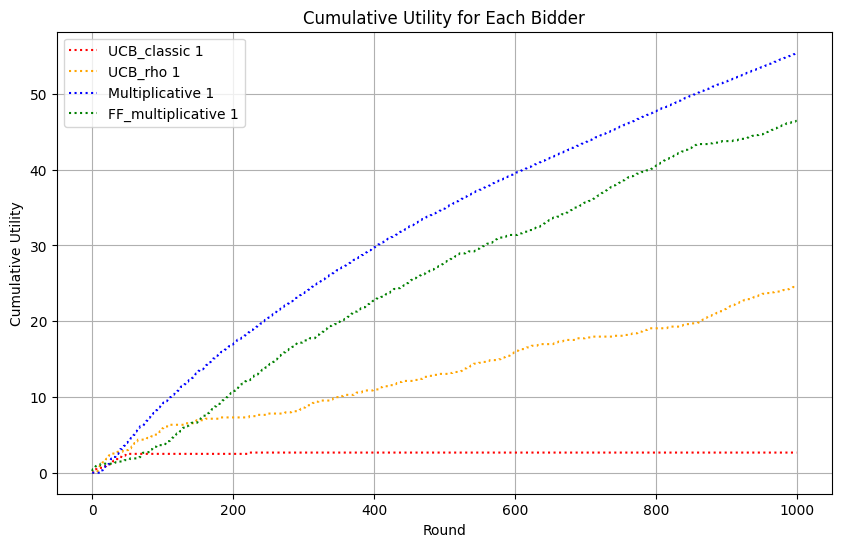

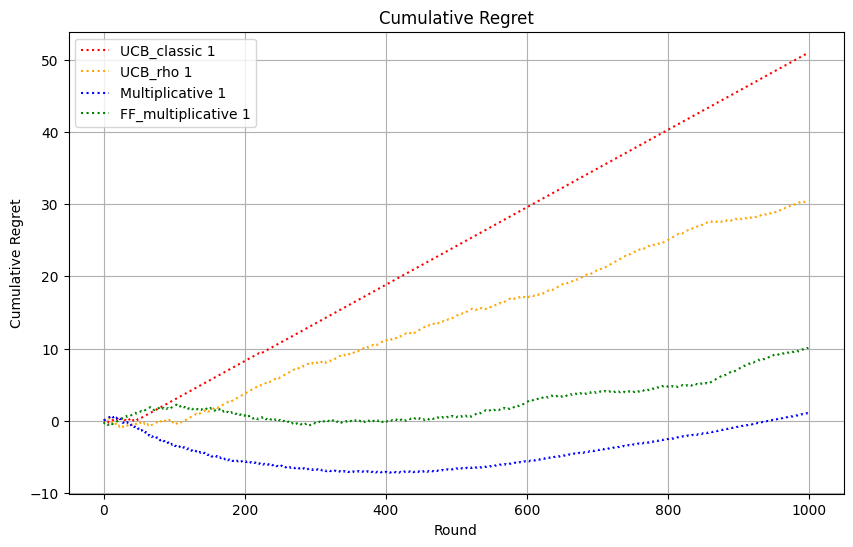

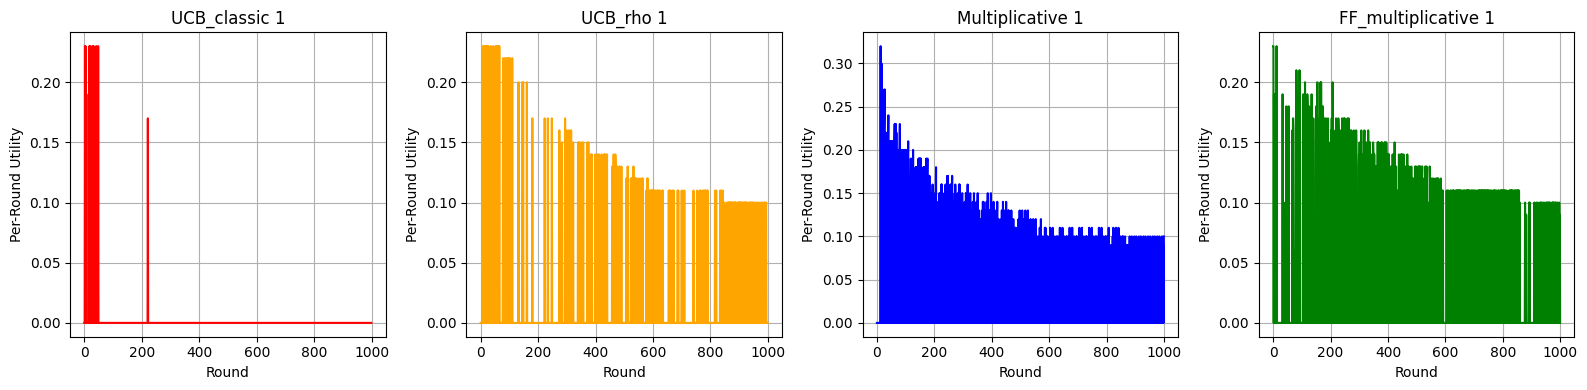

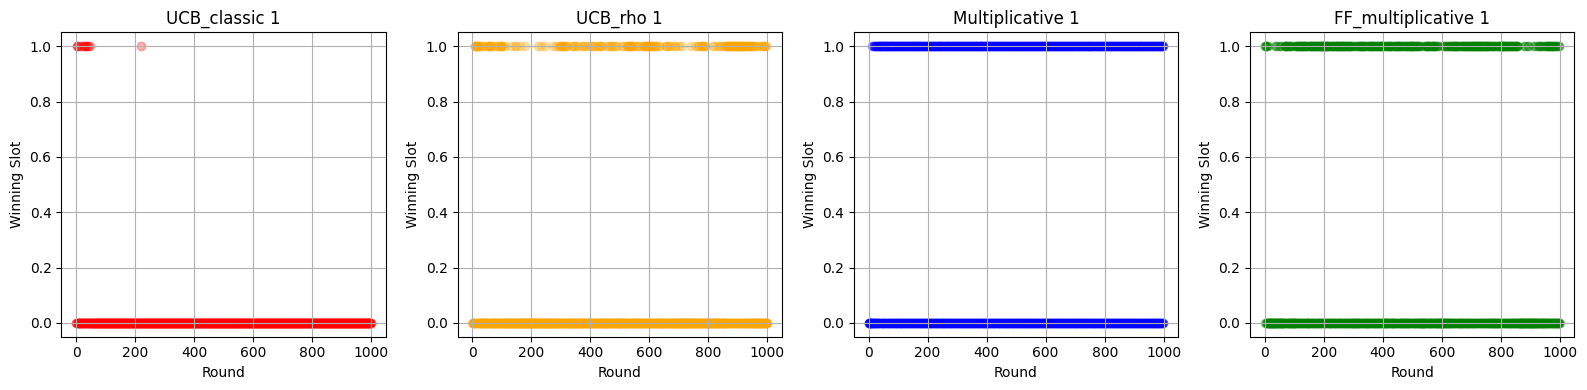

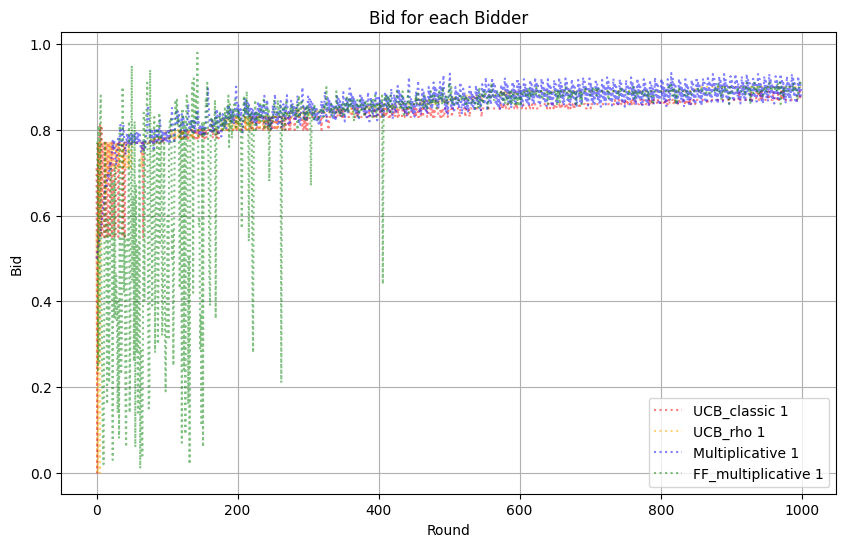

In [31]:
n_users = 1000
lambdas = [1] 
valuations = [1]
rho = 0.4
budget = n_users * rho

problem_params = {"n_users" : n_users, "lambdas" : lambdas,
                 "budget" : budget, "valuations" : valuations,
                 "name_file" : "simple_case"}

random.seed(42)

req = Requirement4(problem_params)
req.run()

### Standard case

Finished bidding rounds

Finished computing clairvoyant

Agents' utility
0 3.3590000000000013 92.30885095395213
1 16.84500000000001 92.43694184273582
2 84.89200000000002 92.79966214819413
3 62.754000000000026 93.42990946233049
4 3.305 114.64830032961135
5 30.145 114.78228819167838
6 106.12 115.4527912459706
7 86.469 115.80545394209226
8 4.895000000000001 135.5360069069717
9 52.33100000000001 135.77124227138523
10 127.95700000000001 135.8617083882656
11 104.70500000000001 136.4765108557495

Cumulative Regret:
Bidder 0: 88.94985095395403
Bidder 1: 75.59194184273507
Bidder 2: 7.907662148194216
Bidder 3: 30.675909462330353
Bidder 4: 111.34330032960942
Bidder 5: 84.63728819167748
Bidder 6: 9.332791245970496
Bidder 7: 29.33645394209202
Bidder 8: 130.64100690697347
Bidder 9: 83.44024227138492
Bidder 10: 7.904708388265595
Bidder 11: 31.771510855749526
(1000, 12)


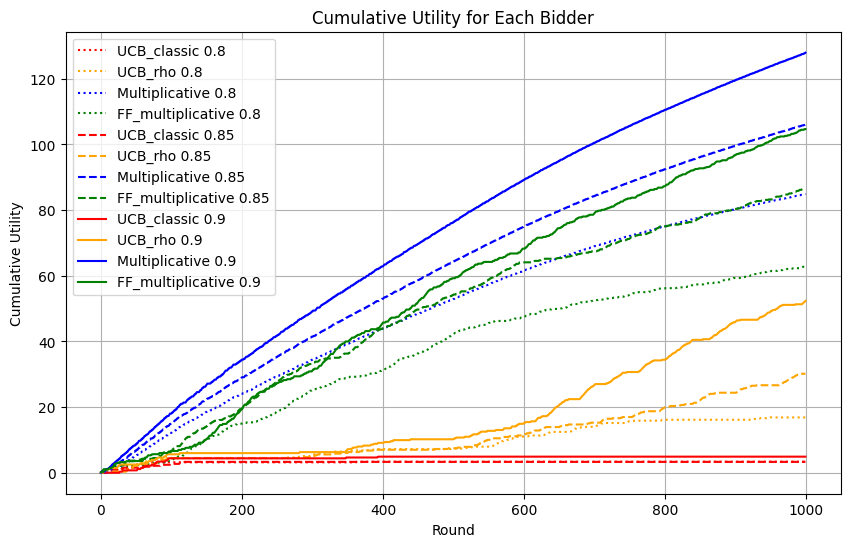

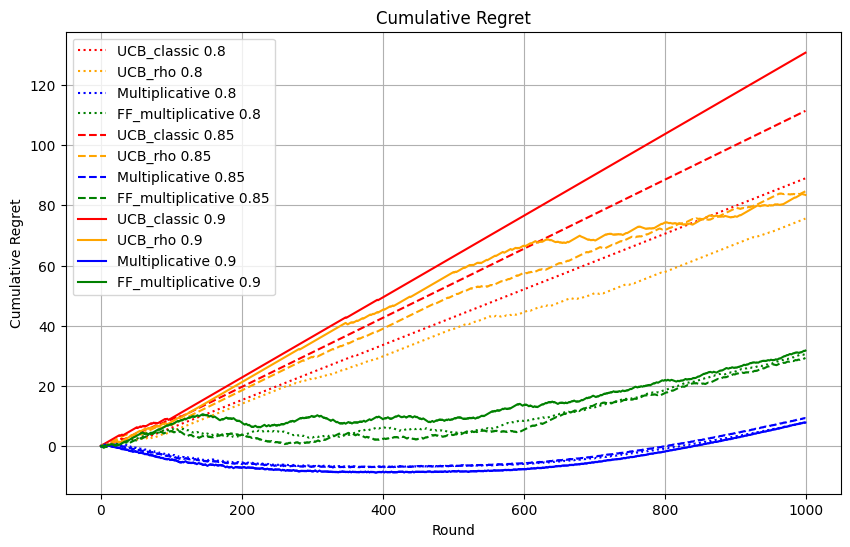

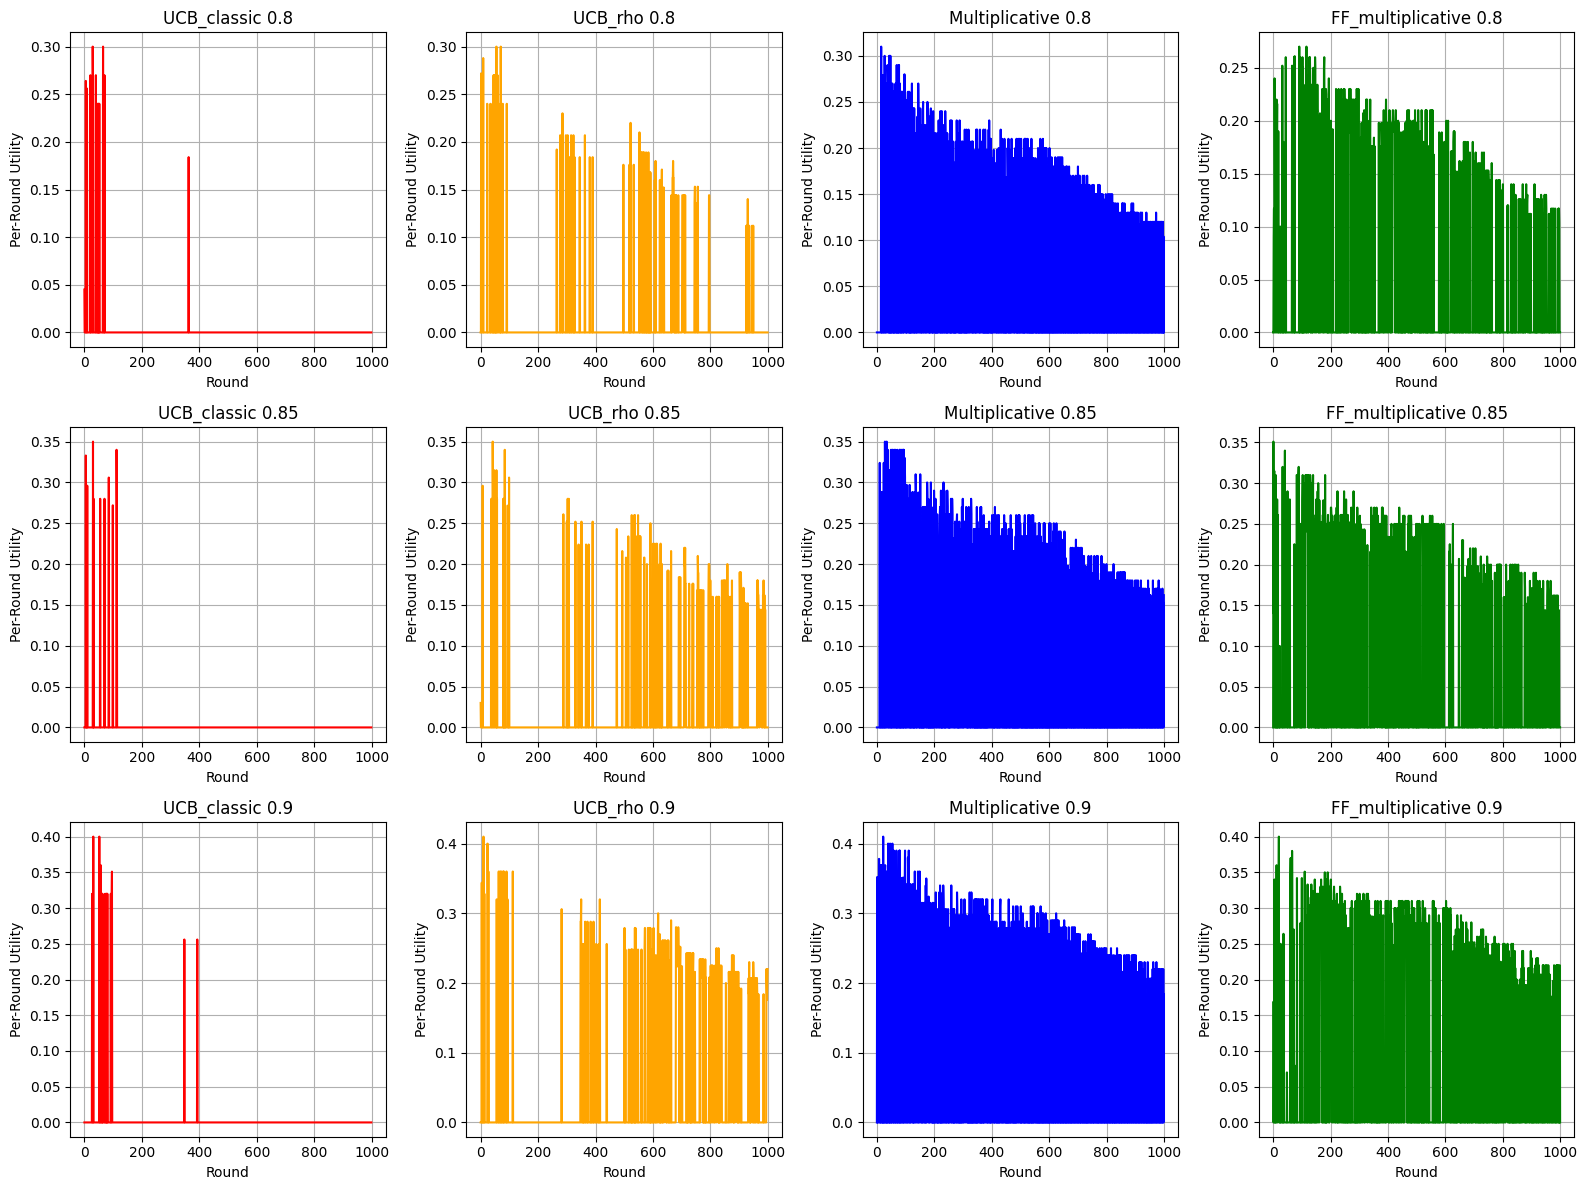

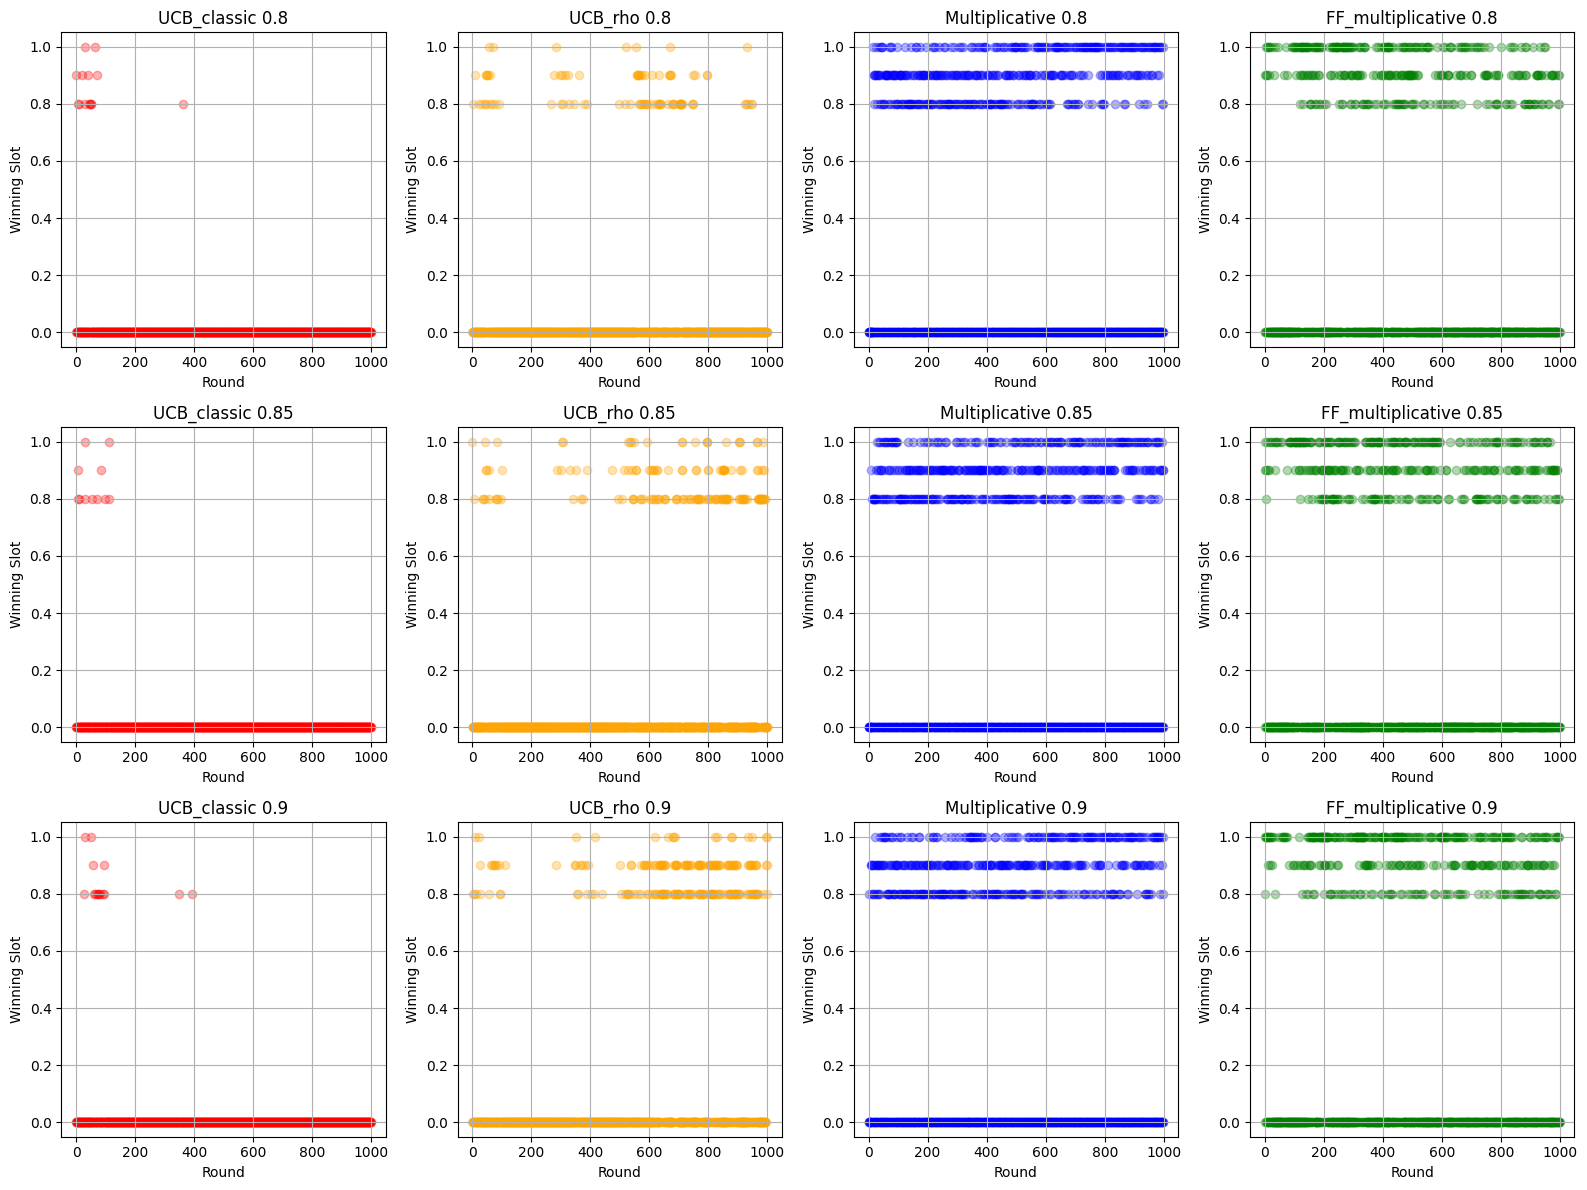

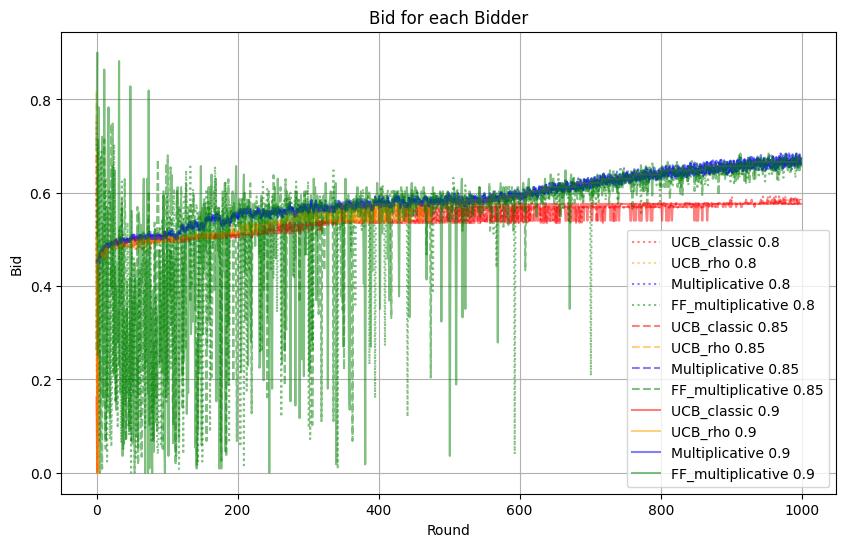

In [32]:
n_users = 1000
lambdas = [0.8, 0.9, 1] # 3 slots
valuations = [0.8, 0.85, 0.9]
rho = 0.25
budget = n_users * rho

problem_params = {"n_users" : n_users, "lambdas" : lambdas,
                 "budget" : budget, "valuations" : valuations,
                 "name_file" : "standard_case"}

random.seed(42)

req = Requirement4(problem_params)
req.run()

### Low budget - different valuations

Finished bidding rounds

Finished computing clairvoyant

Agents' utility
0 0.356 1.911
1 1.6879999999999997 1.911
2 0.5029999999999999 2.262
3 0.9170000000000001 1.7550000000000003
4 92.01400000000001 96.86952109292898
5 91.918 96.46071356280696
6 94.617 96.37939901330542
7 83.11500000000001 96.52393775153722
8 179.735 195.89775188235424
9 179.66600000000003 195.9167705715902
10 184.59900000000002 196.1526252585229
11 149.74400000000003 195.9596657816648

Cumulative Regret:
Bidder 0: 1.5549999999999968
Bidder 1: 0.22299999999999687
Bidder 2: 1.7589999999999872
Bidder 3: 0.8379999999999668
Bidder 4: 4.855521092928944
Bidder 5: 4.542713562806939
Bidder 6: 1.7623990133054765
Bidder 7: 13.40893775153703
Bidder 8: 16.162751882354144
Bidder 9: 16.250770571590277
Bidder 10: 11.553625258523335
Bidder 11: 46.21566578166476
(1000, 12)


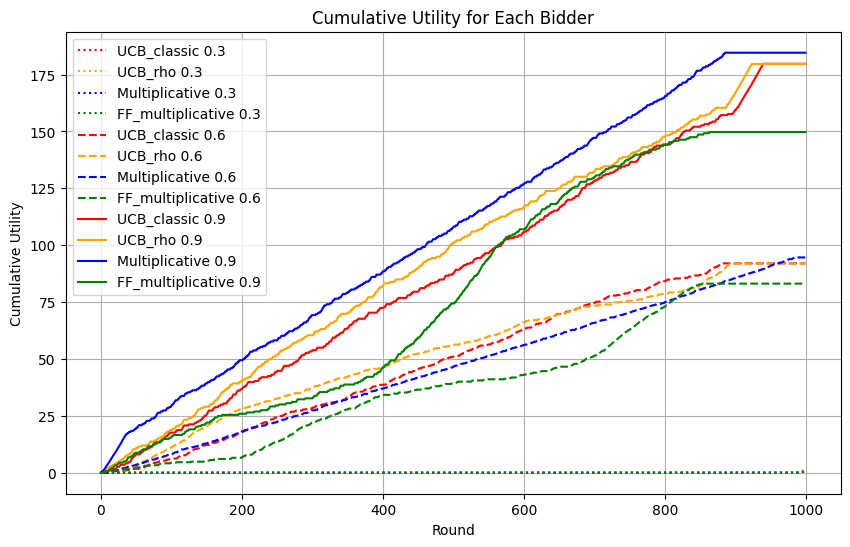

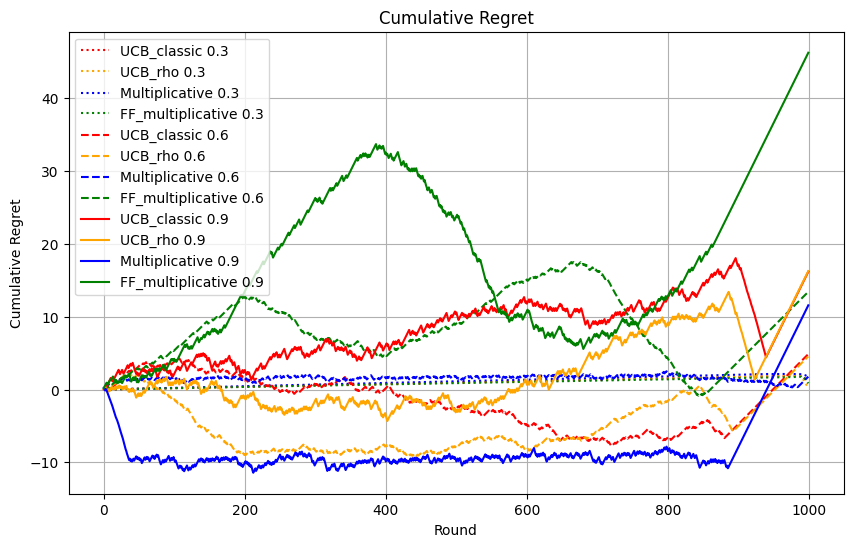

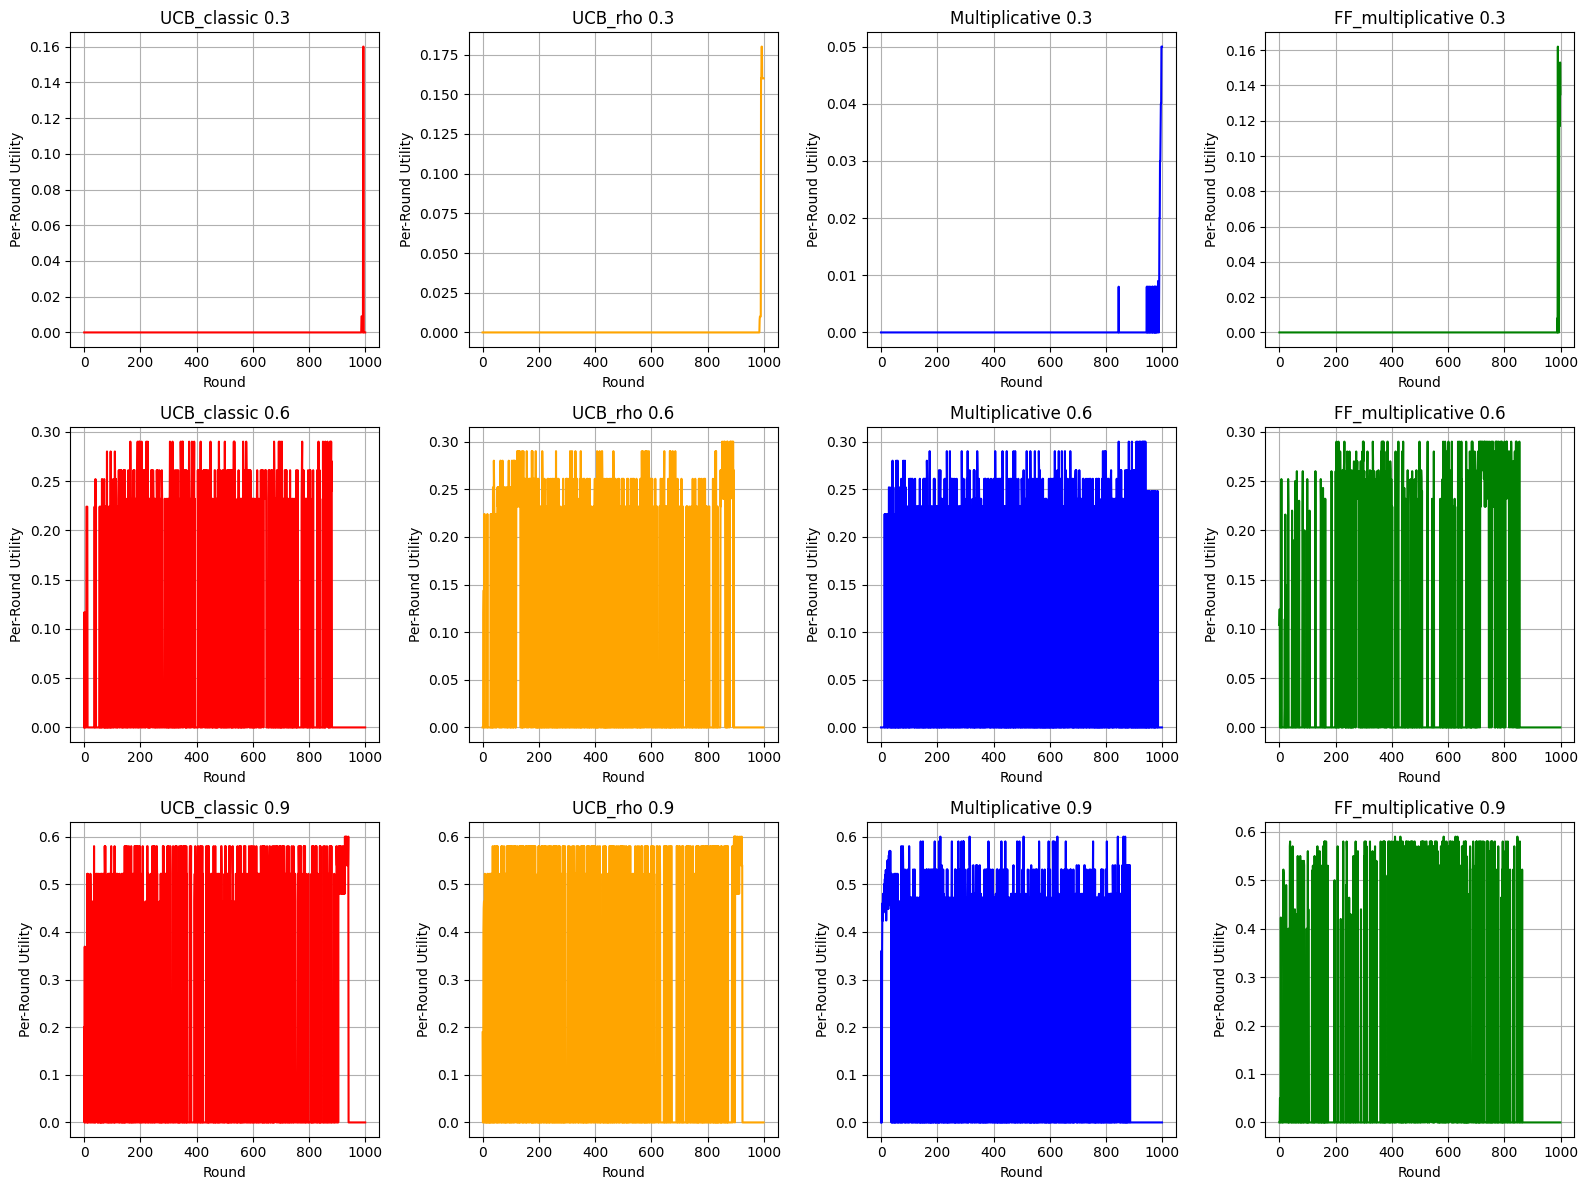

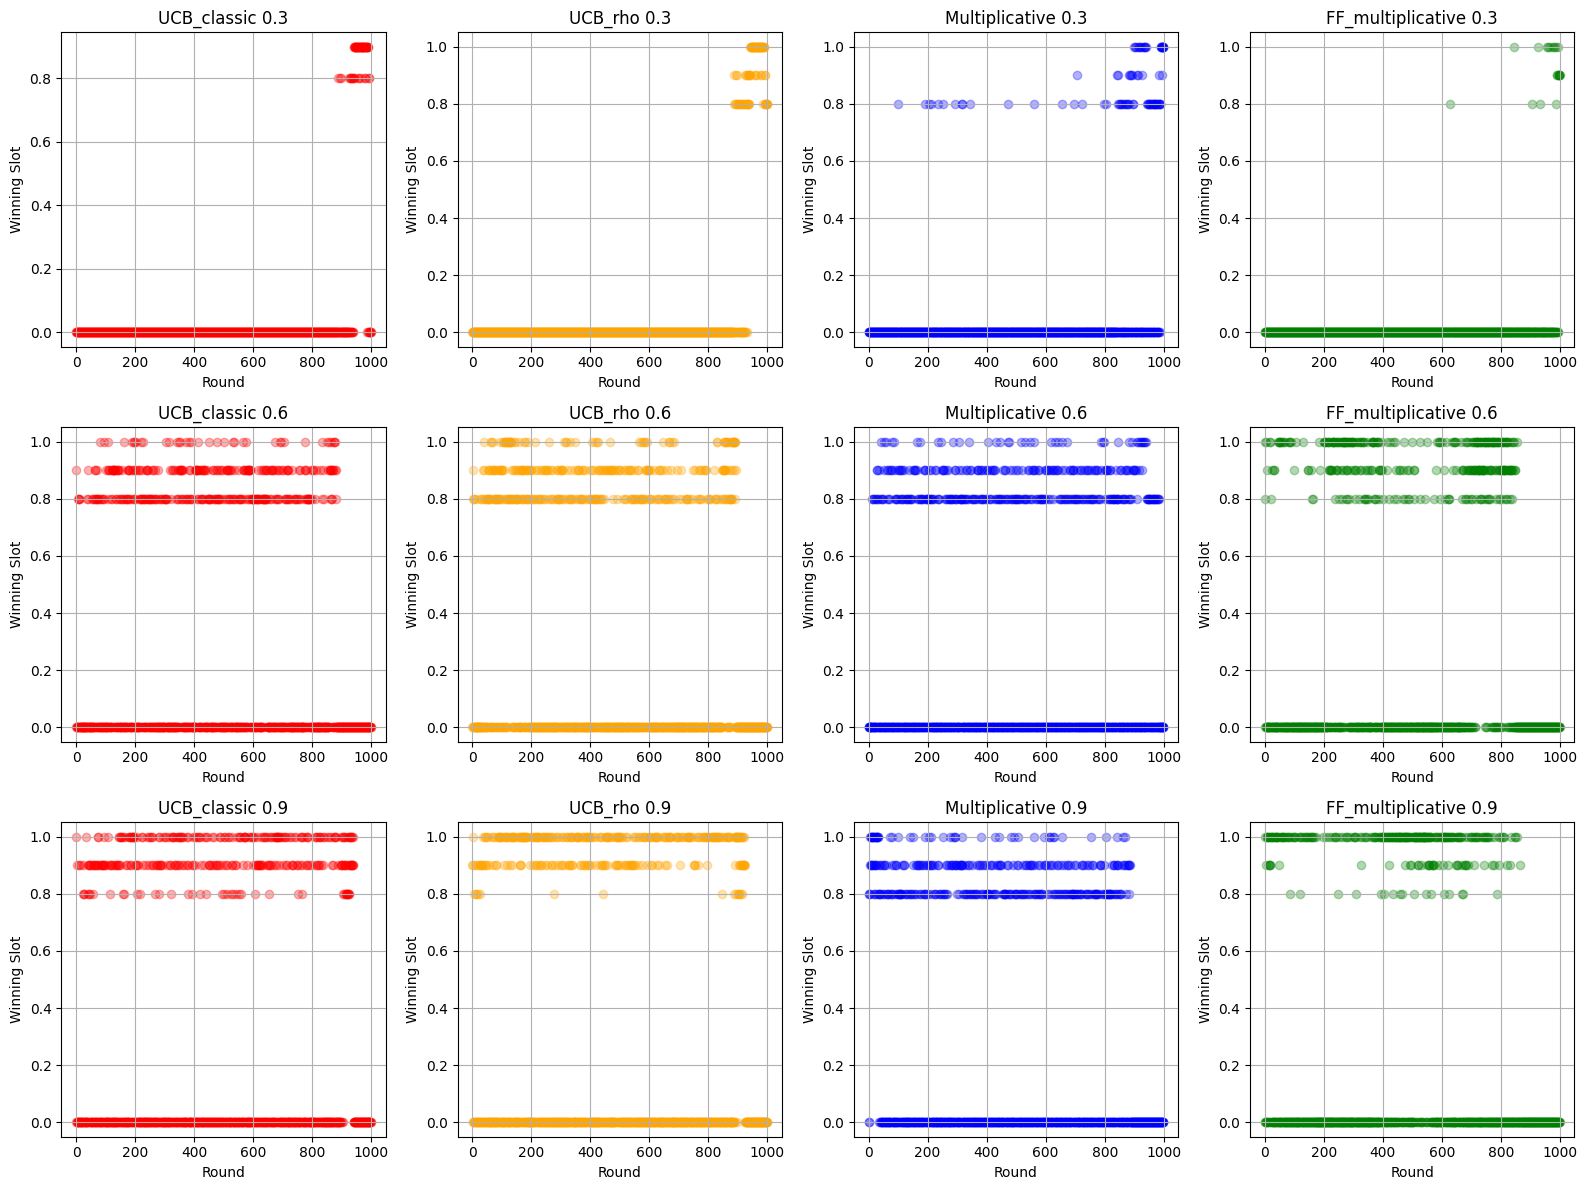

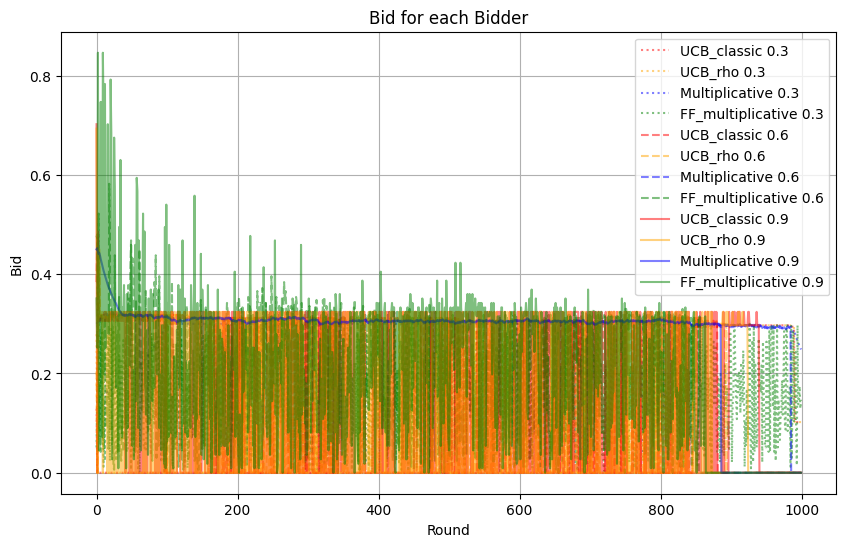

In [33]:
n_users = 1000
lambdas = [0.8, 0.9, 1] # 3 slots
valuations = [0.3, 0.6, 0.9]
rho = 0.1
budget = n_users * rho

problem_params = {"n_users" : n_users, "lambdas" : lambdas,
                 "budget" : budget, "valuations" : valuations,
                 "name_file" : "different_valuations"}

random.seed(42)

req = Requirement4(problem_params)
req.run()

### High budget

Finished bidding rounds

Finished computing clairvoyant

Agents' utility
0 0.14400000000000013 7.044
1 0.8260000000000004 7.044
2 7.978000000000005 7.5840000000000005
3 1.328000000000001 7.1160000000000005
4 1.4719999999999998 16.251081778171635
5 6.273999999999999 16.79566967845831
6 21.349999999999998 16.77236858358069
7 13.860999999999997 16.758629962172154
8 2.707 46.390796033963504
9 28.897000000000016 48.27015166721245
10 51.90500000000003 47.73373933127871
11 42.74200000000001 47.87249975722479

Cumulative Regret:
Bidder 0: 6.899999999999862
Bidder 1: 6.2179999999999
Bidder 2: -0.39400000000016344
Bidder 3: 5.787999999999935
Bidder 4: 14.779081778171838
Bidder 5: 10.521669678458416
Bidder 6: -4.577631416419175
Bidder 7: 2.8976299621721746
Bidder 8: 43.68379603396322
Bidder 9: 19.373151667212365
Bidder 10: -4.1712606687213984
Bidder 11: 5.1304997572248
(1000, 12)


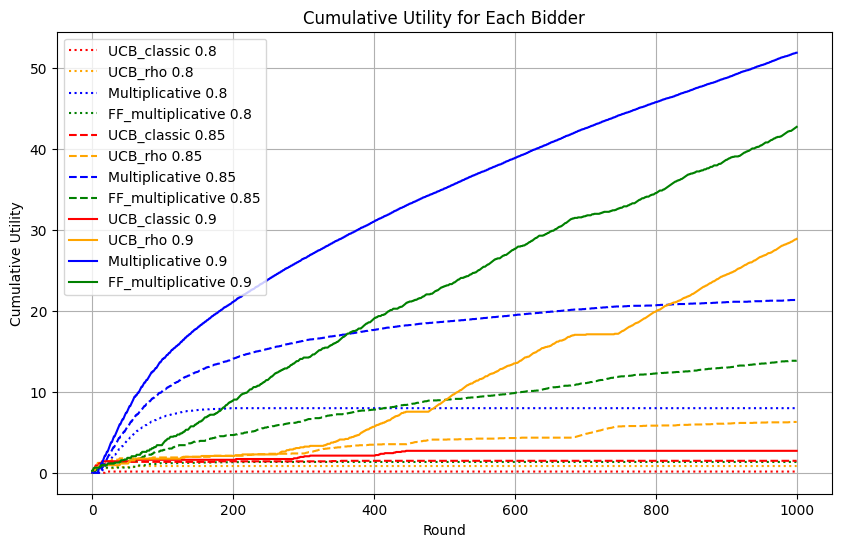

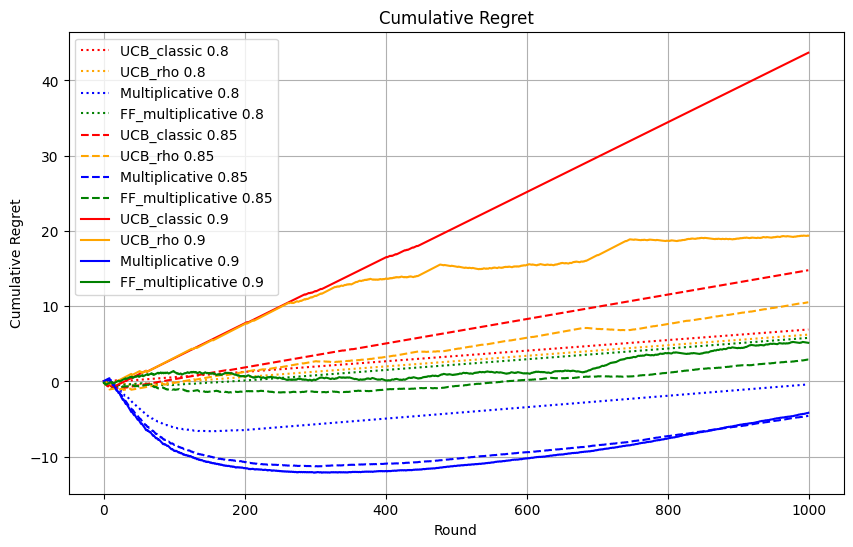

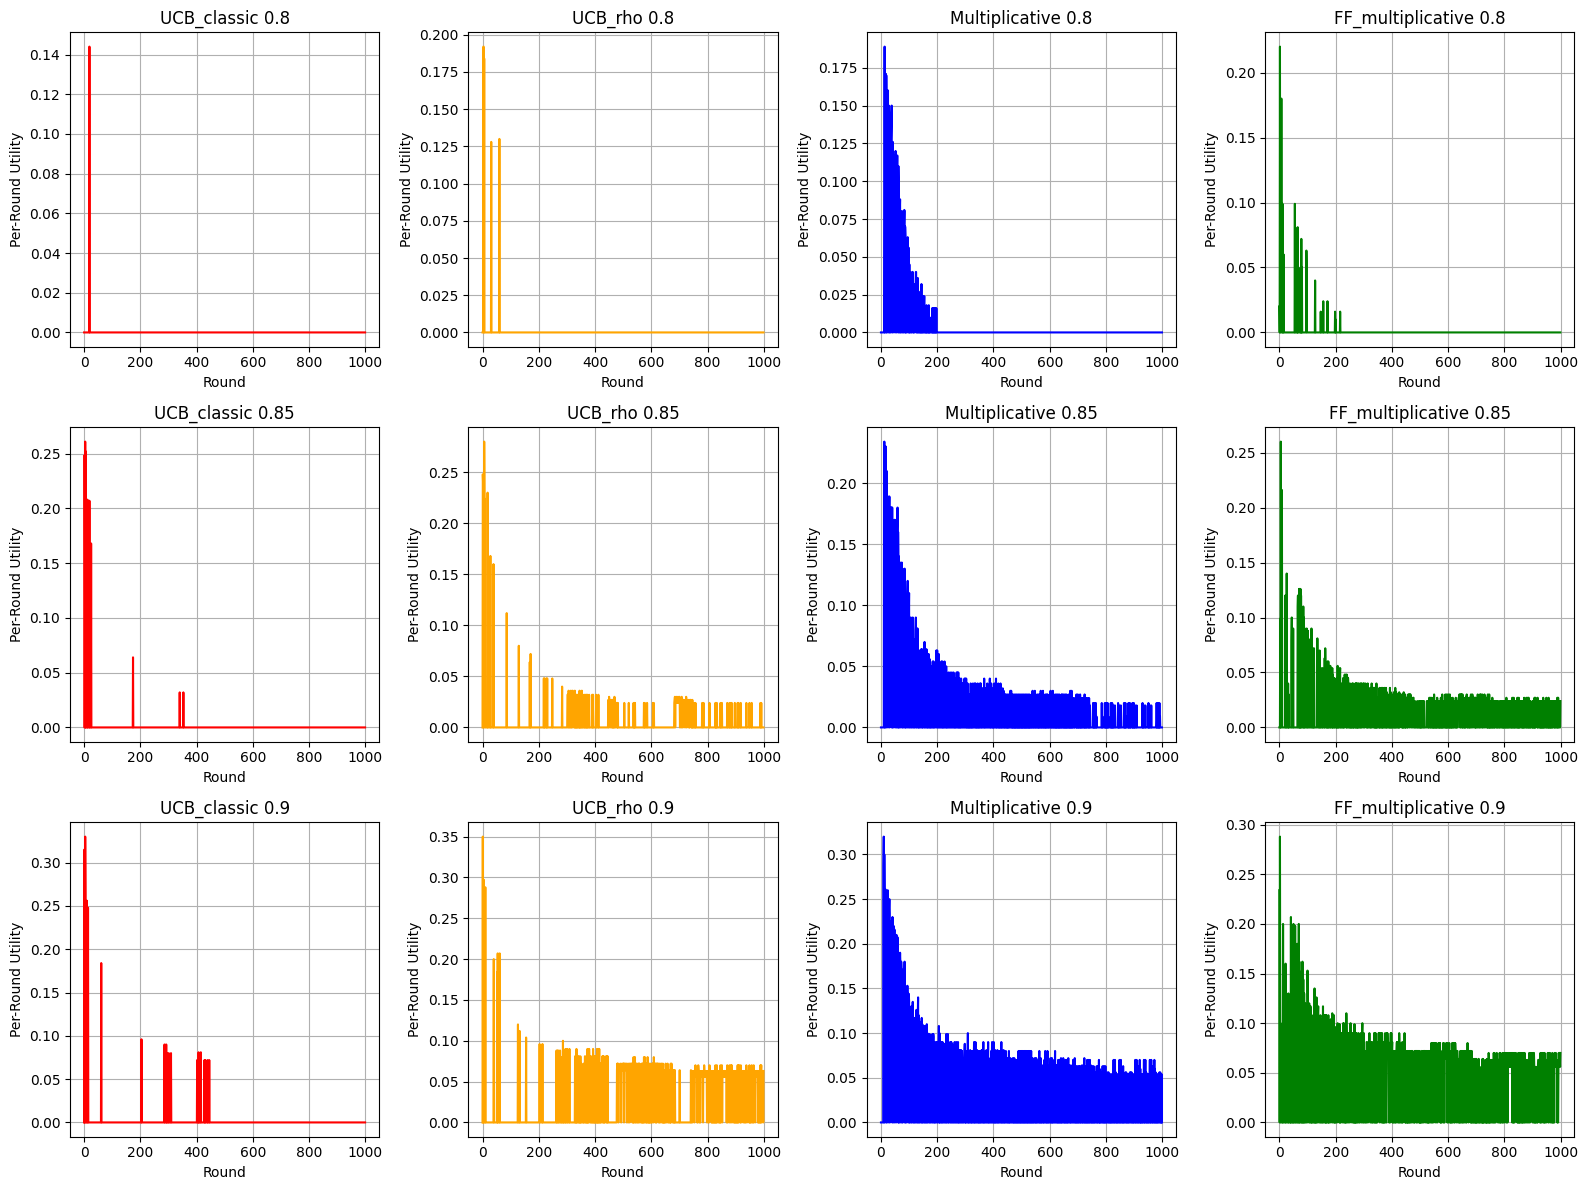

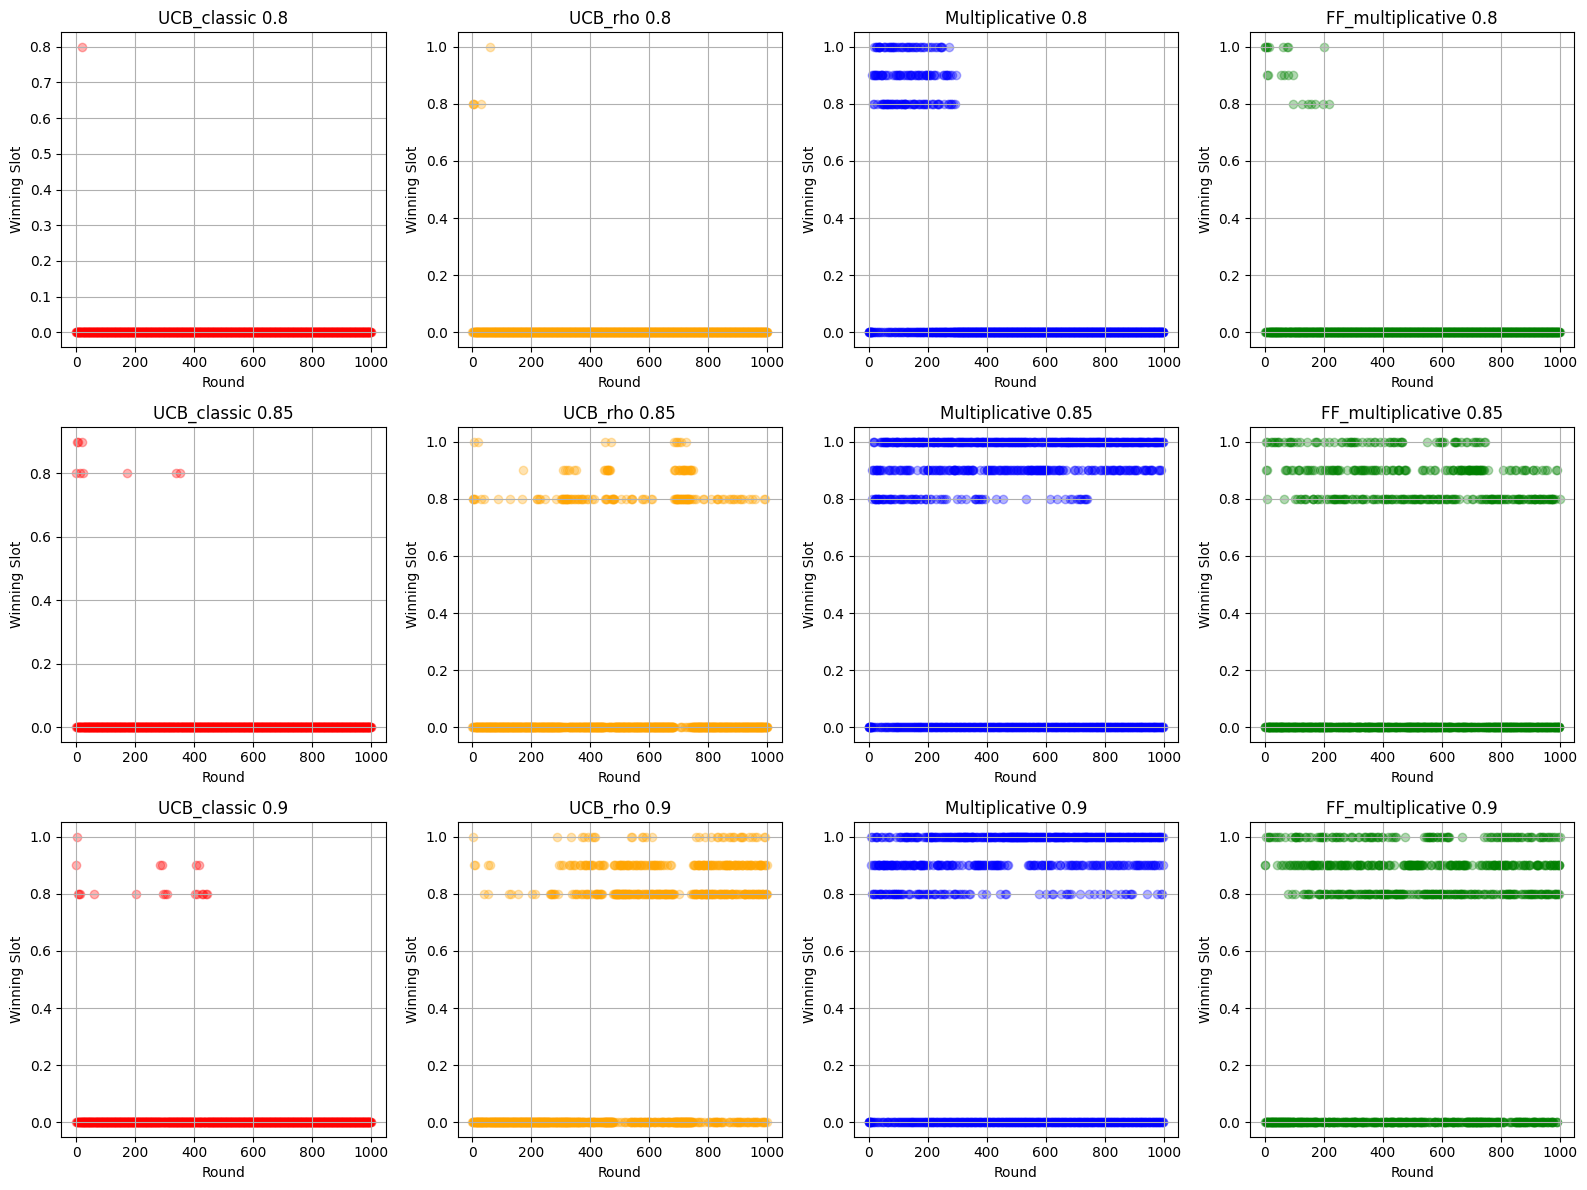

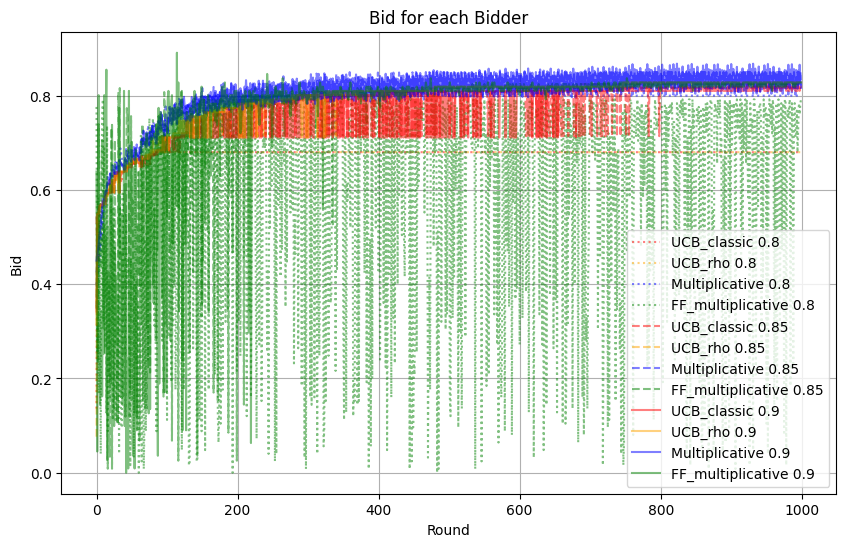

In [34]:
n_users = 1000
lambdas = [0.8, 0.9, 1] # 3 slots
valuations = [0.8, 0.85, 0.9]
rho = 0.5
budget = n_users * rho

problem_params = {"n_users" : n_users, "lambdas" : lambdas,
                 "budget" : budget, "valuations" : valuations,
                 "name_file" : "high_budget"}

random.seed(137)

req = Requirement4(problem_params)
req.run()

### Very high budget

Finished bidding rounds

Finished computing clairvoyant

Agents' utility
0 0.2290000000000001 1.094400000000001
1 0.4400000000000003 1.094400000000001
2 0.2830000000000005 1.6320000000000014
3 0.10000000000000009 1.104000000000001
4 0.732 2.0221499999999977
5 1.2249999999999996 2.0221499999999977
6 2.8419999999999996 2.485399999999999
7 0.7330000000000002 2.0680499999999973
8 2.705000000000002 39.63587989929898
9 17.975000000000016 39.65527436012566
10 30.084000000000024 39.81838387225208
11 38.14900000000003 39.67629642369995

Cumulative Regret:
Bidder 0: 0.8654000000000146
Bidder 1: 0.6544000000000038
Bidder 2: 1.3490000000000082
Bidder 3: 1.003999999999996
Bidder 4: 1.2901499999999728
Bidder 5: 0.7971499999999733
Bidder 6: -0.35659999999999714
Bidder 7: 1.3350500000000072
Bidder 8: 36.93087989929977
Bidder 9: 21.680274360125683
Bidder 10: 9.734383872252003
Bidder 11: 1.527296423699862
(1000, 12)


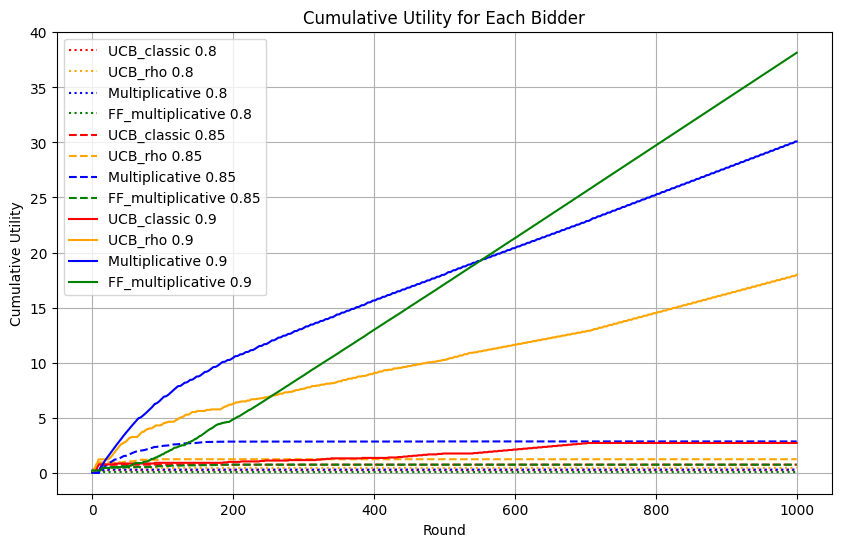

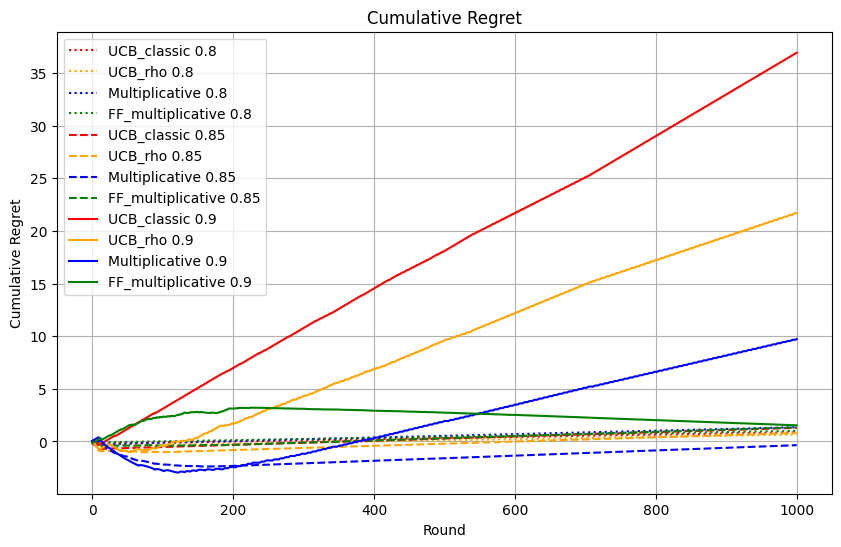

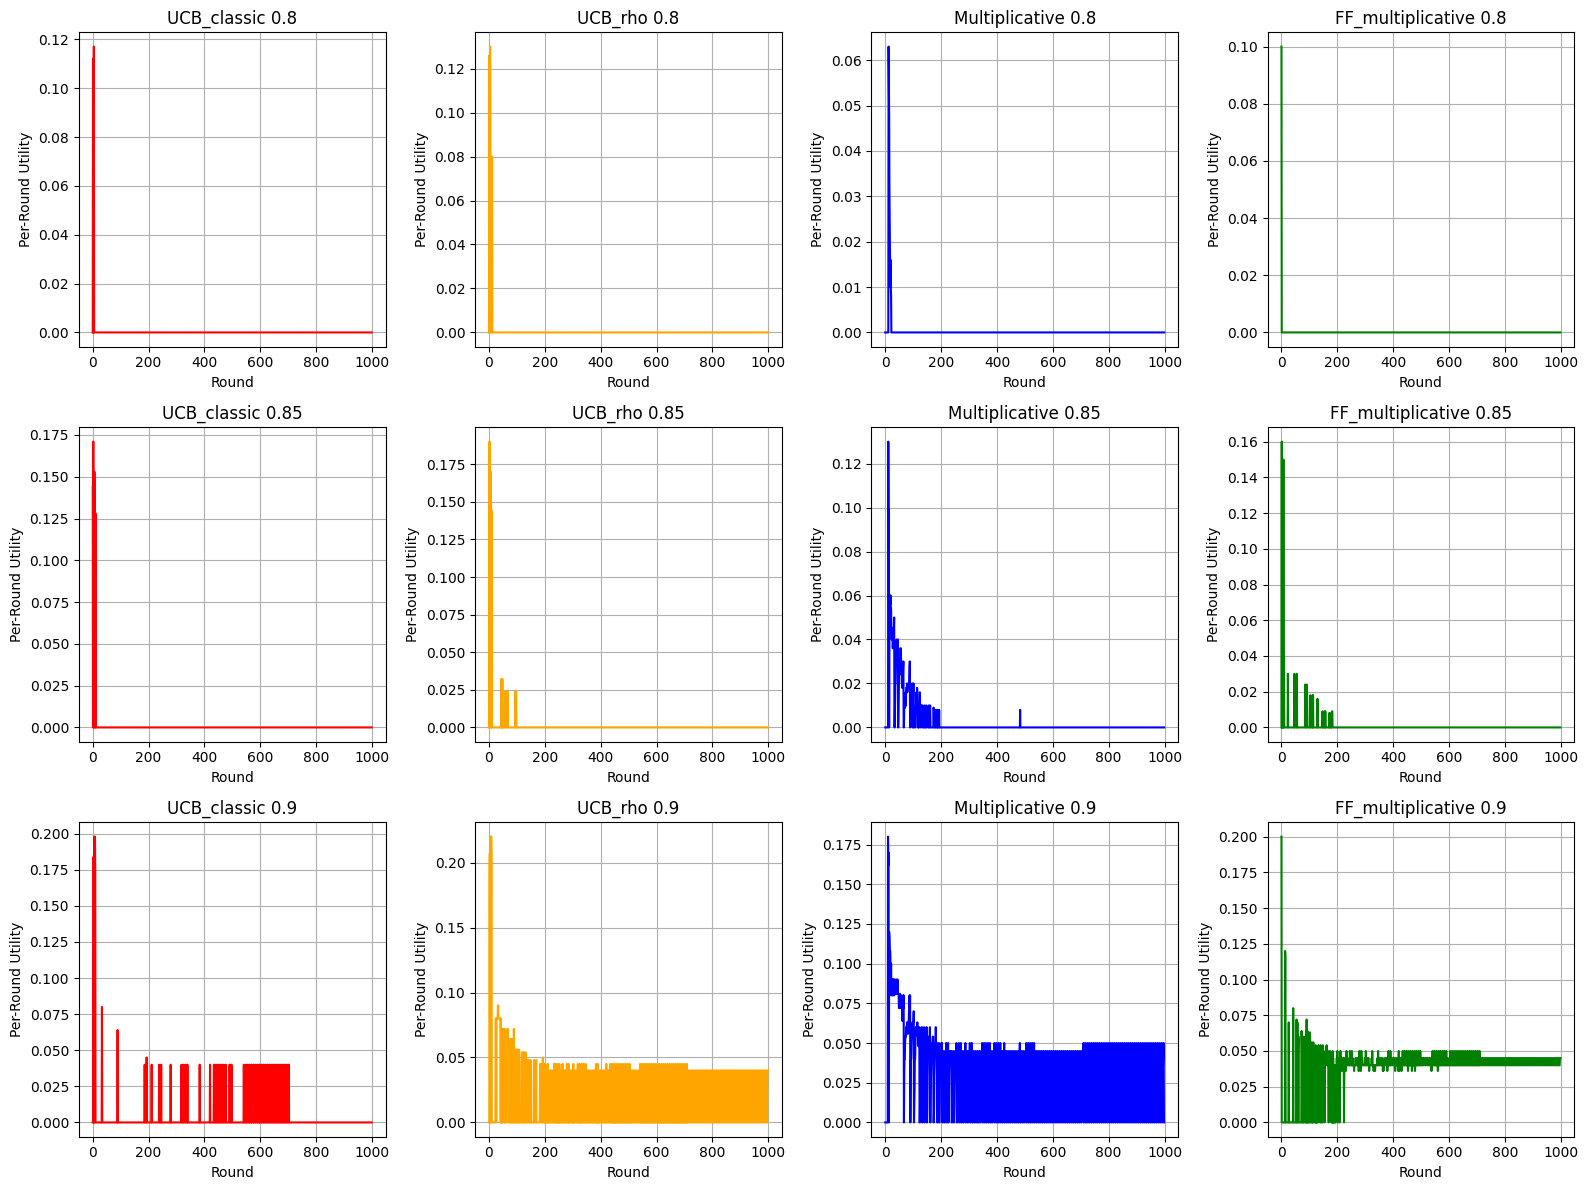

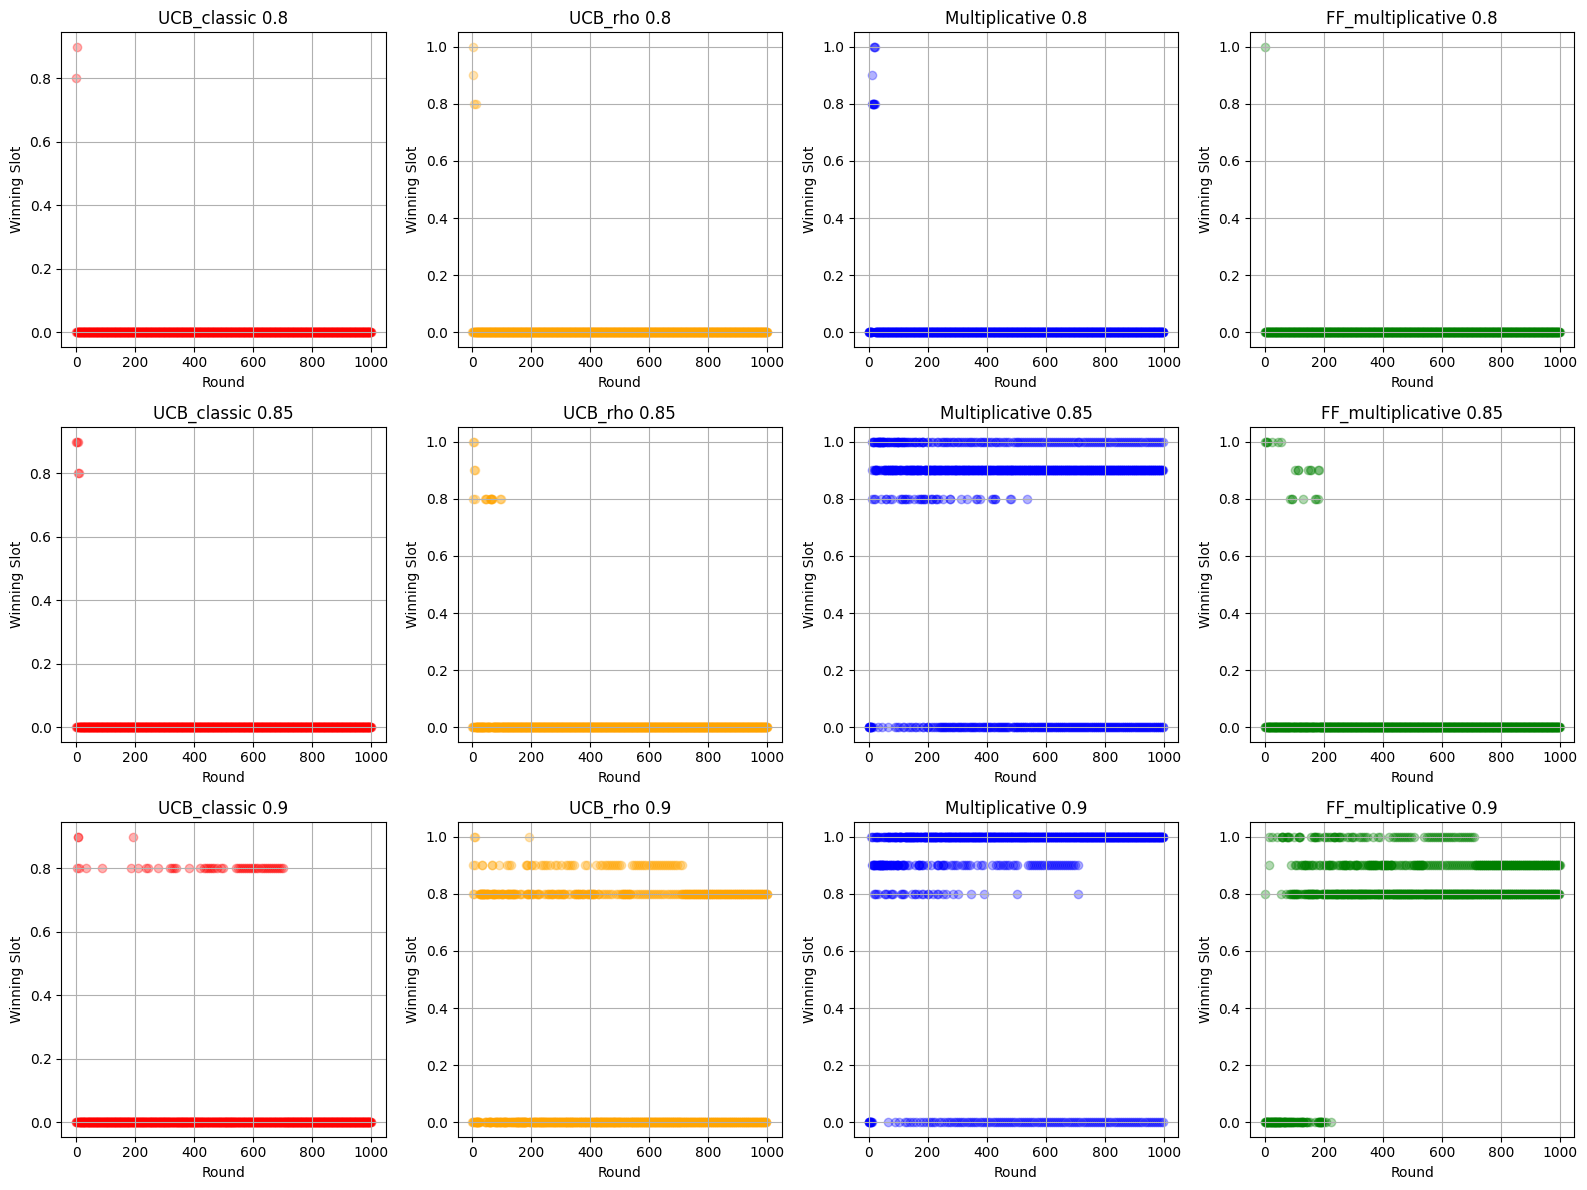

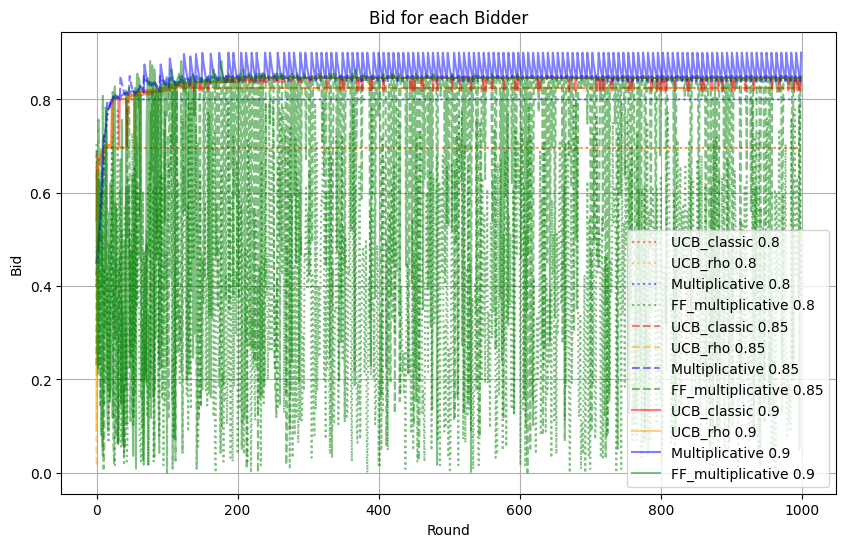

In [35]:
n_users = 1000
lambdas = [0.8, 0.9, 1] # 3 slots
valuations = [0.8, 0.85, 0.9]
rho = 0.75
budget = n_users * rho

problem_params = {"n_users" : n_users, "lambdas" : lambdas,
                 "budget" : budget, "valuations" : valuations,
                 "name_file" : "very_high_budget"}

random.seed(137)

req = Requirement4(problem_params)
req.run()

### Many Slots

Finished bidding rounds

Finished computing clairvoyant

Agents' utility
0 91.11800000000001 172.87711221318412
1 172.53400000000005 179.986908997682
2 171.26700000000002 187.98031113460945
3 173.00800000000004 185.0681342898911
4 119.215 202.05014874895687
5 195.01100000000002 206.44988932456357
6 198.128 214.77963177794
7 194.811 211.81891540237896
8 146.54200000000003 230.47533413038616
9 212.47100000000006 234.4616270767762
10 225.17400000000004 243.1066281269211
11 222.13400000000007 240.47786596506614

Cumulative Regret:
Bidder 0: 81.75911221318434
Bidder 1: 7.452908997682029
Bidder 2: 16.713311134609405
Bidder 3: 12.060134289891062
Bidder 4: 82.83514874895693
Bidder 5: 11.438889324563553
Bidder 6: 16.651631777939986
Bidder 7: 17.007915402378917
Bidder 8: 83.93333413038685
Bidder 9: 21.990627076776093
Bidder 10: 17.93262812692109
Bidder 11: 18.343865965066154
(1000, 12)


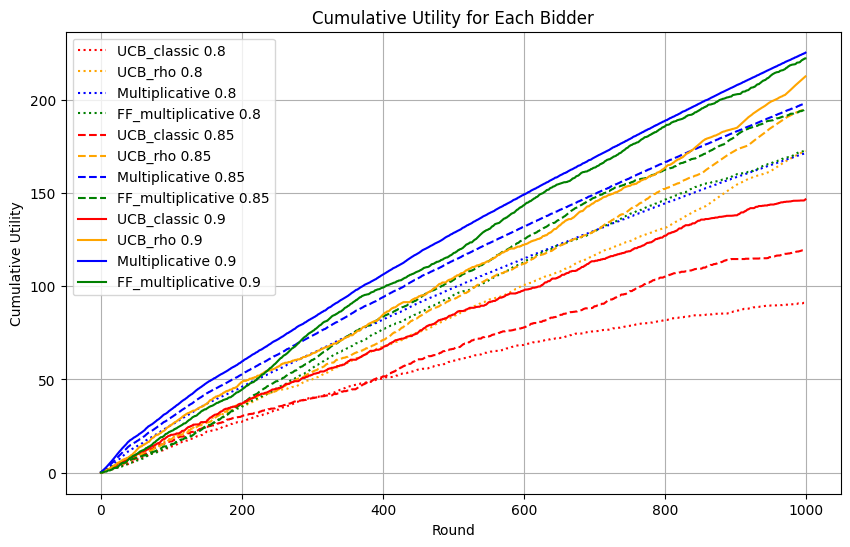

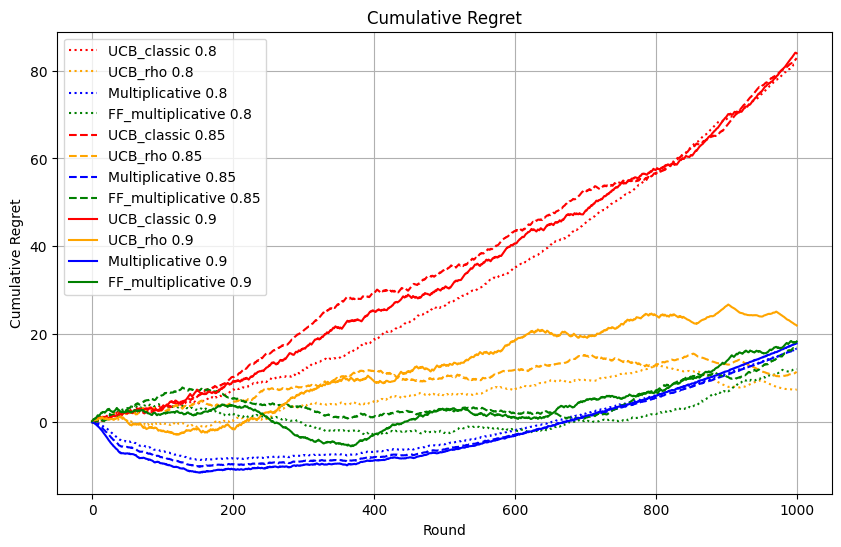

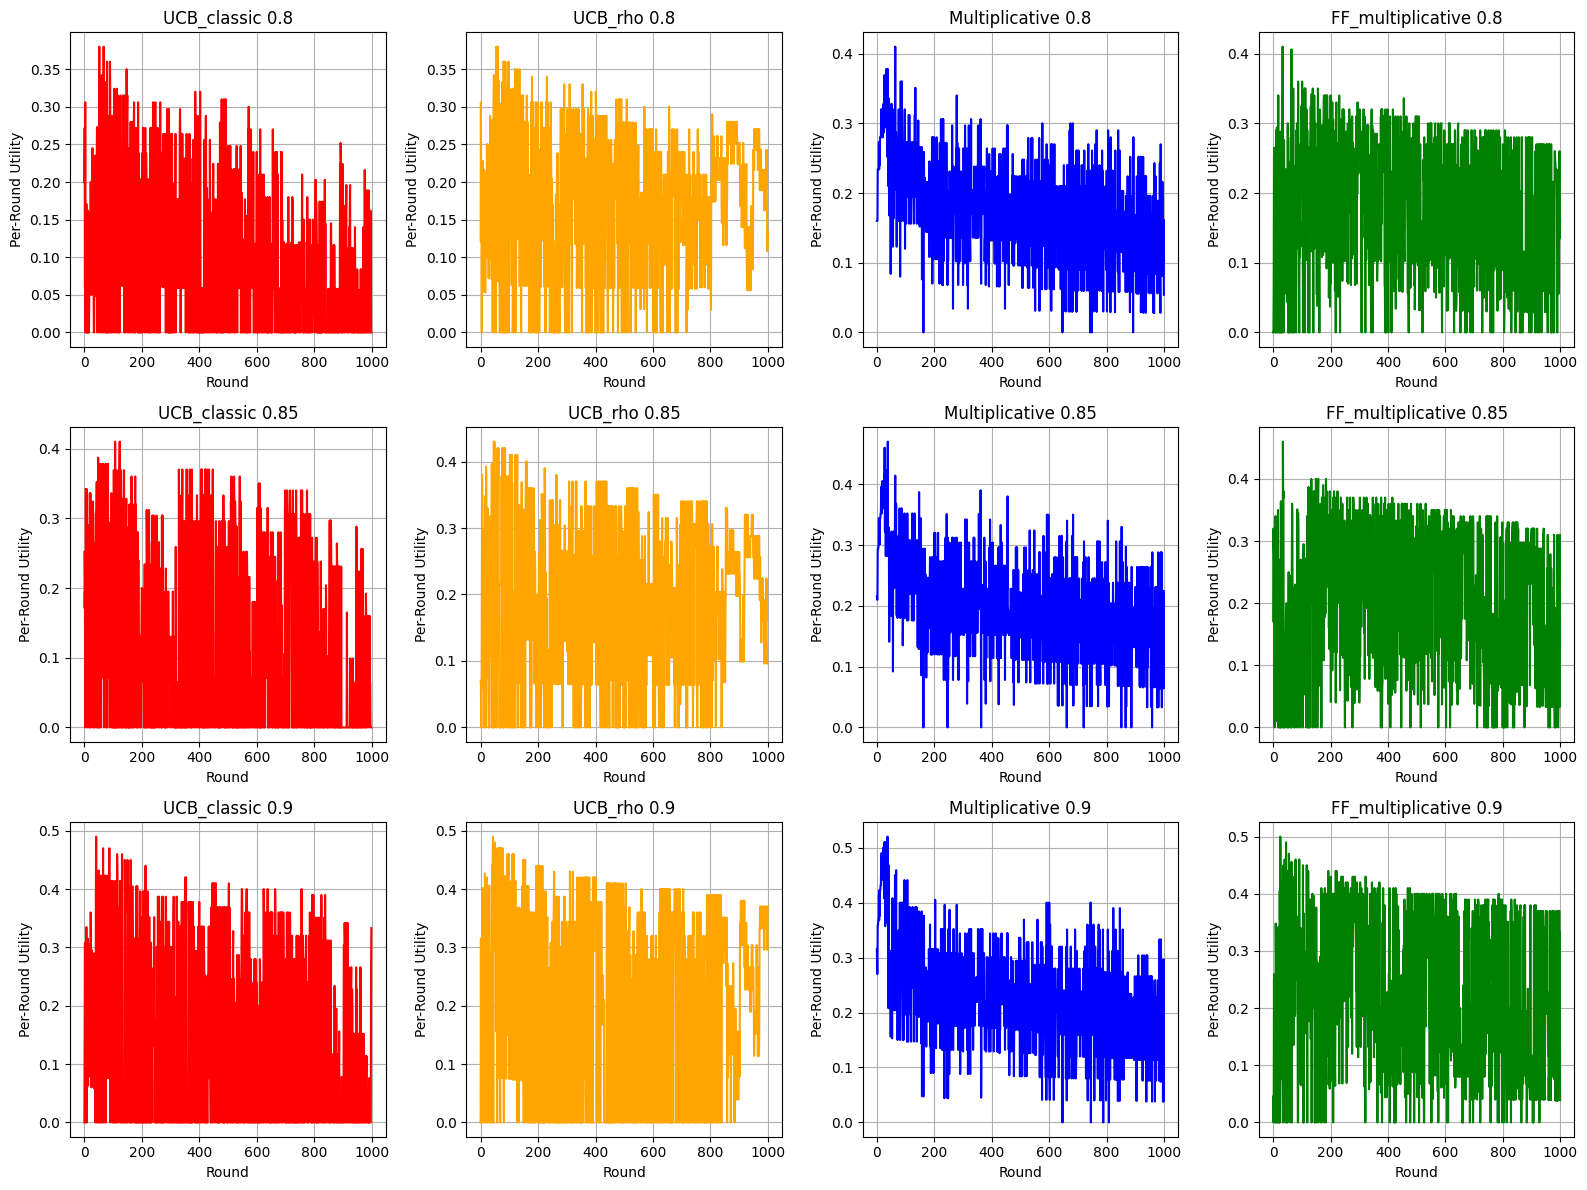

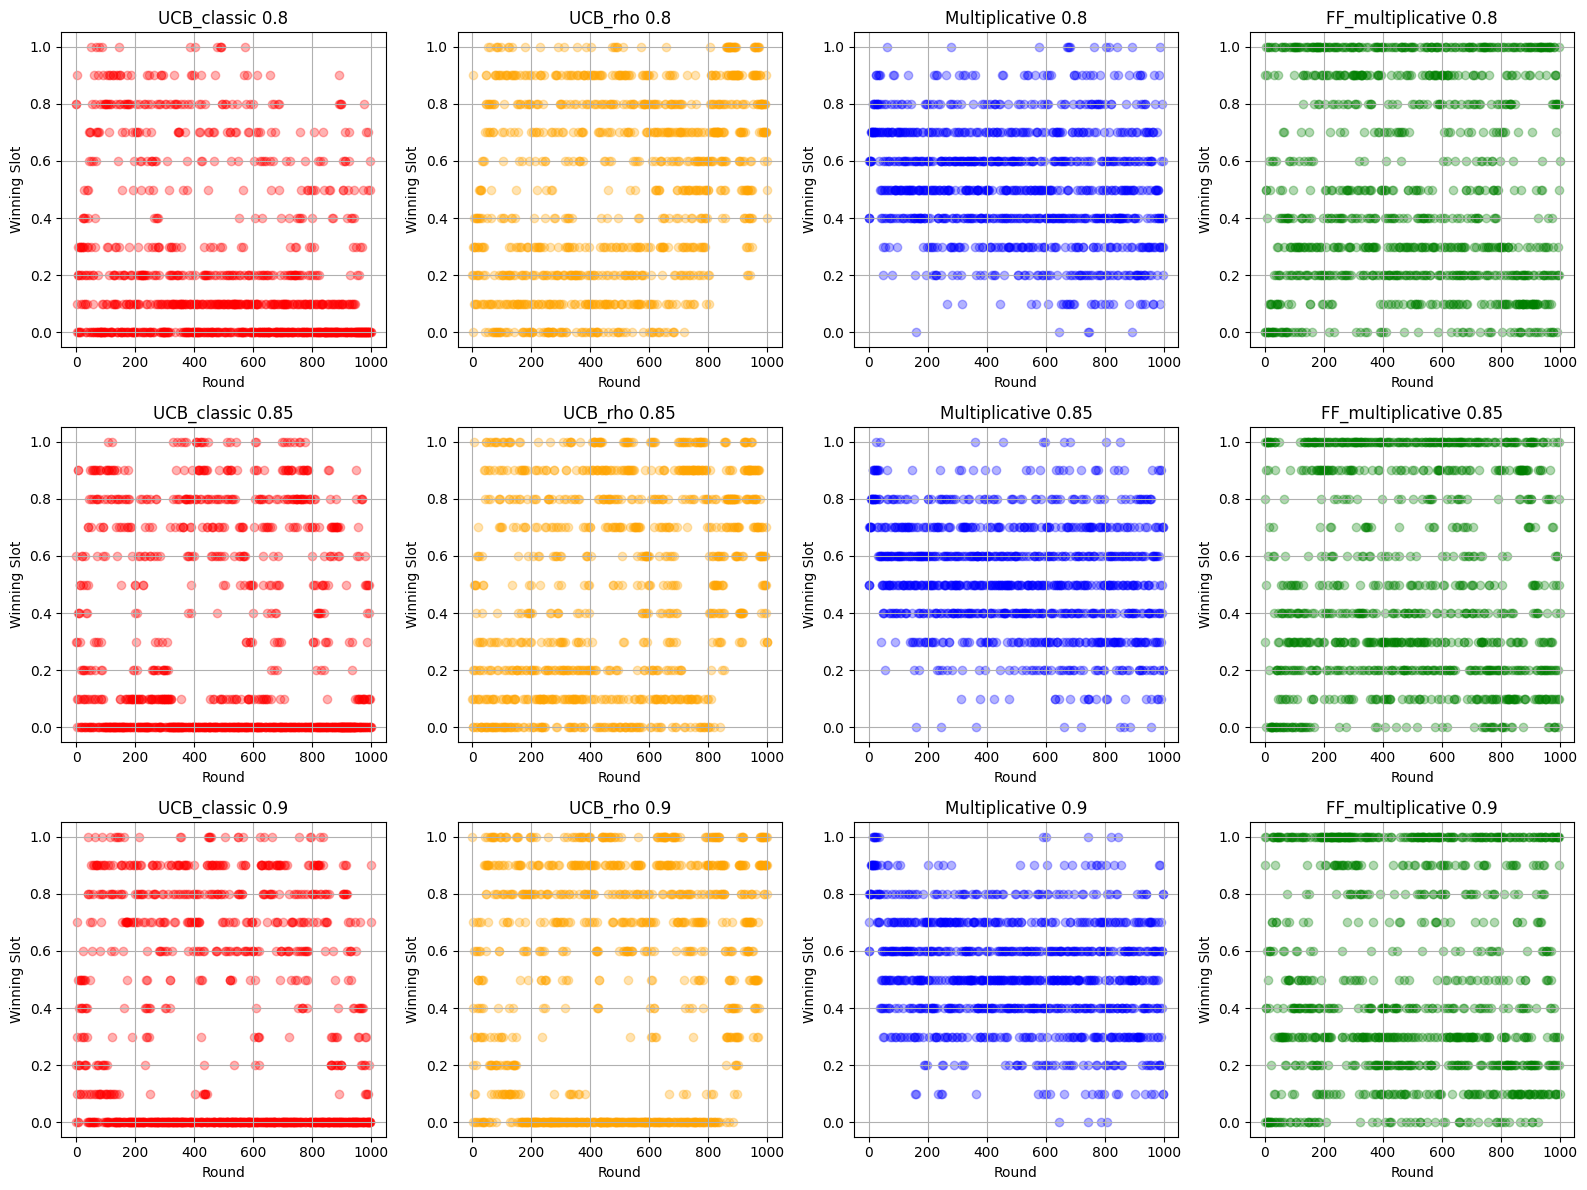

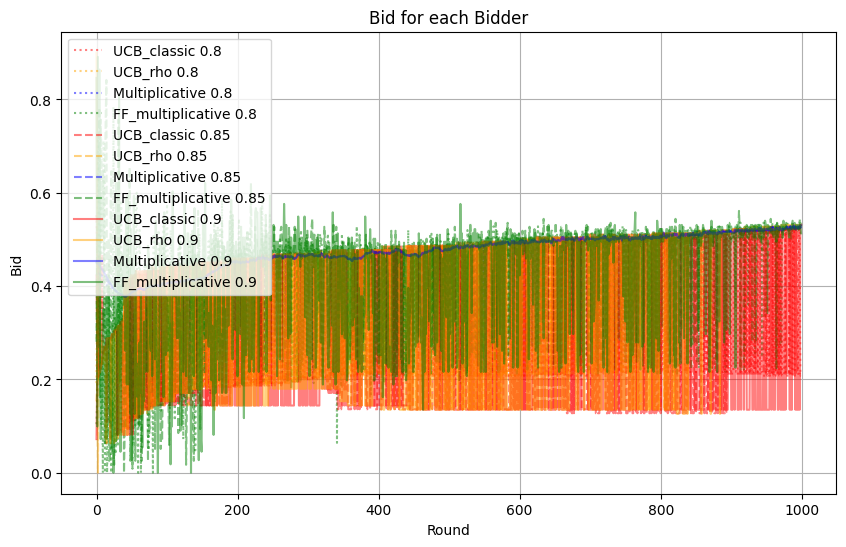

In [36]:
n_users = 1000
lambdas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # 10 slots
valuations = [0.8, 0.85, 0.9]
rho = 0.25
budget = n_users * rho

problem_params = {"n_users" : n_users, "lambdas" : lambdas,
                 "budget" : budget, "valuations" : valuations,
                 "name_file" : "many_slots"}

random.seed(313)

req = Requirement4(problem_params)
req.run()

### Single Slot

Finished bidding rounds

Finished computing clairvoyant

Agents' utility
0 0.050000000000000044 1.8240000000000016
1 0.29000000000000026 1.8240000000000016
2 0.6900000000000006 1.9840000000000018
3 0.020000000000000018 1.8560000000000016
4 0.6199999999999999 6.142668718399621
5 0.4999999999999999 6.149739647904764
6 4.579999999999998 6.815604100756847
7 1.740000000000001 6.680999999999992
8 0.5900000000000001 21.194603709949398
9 8.200000000000006 21.453258312670847
10 17.190000000000012 22.004689331770205
11 11.86000000000001 22.348603287734207

Cumulative Regret:
Bidder 0: 1.774000000000032
Bidder 1: 1.5340000000000251
Bidder 2: 1.2939999999999916
Bidder 3: 1.8360000000000305
Bidder 4: 5.522668718399507
Bidder 5: 5.649739647904701
Bidder 6: 2.235604100756822
Bidder 7: 4.941000000000005
Bidder 8: 20.60460370994954
Bidder 9: 13.25325831267059
Bidder 10: 4.814689331770211
Bidder 11: 10.488603287734128
(1000, 12)


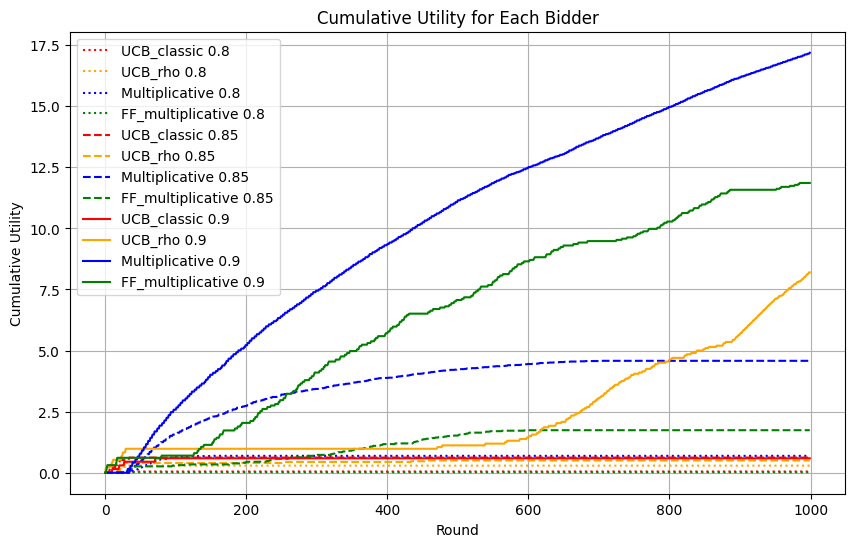

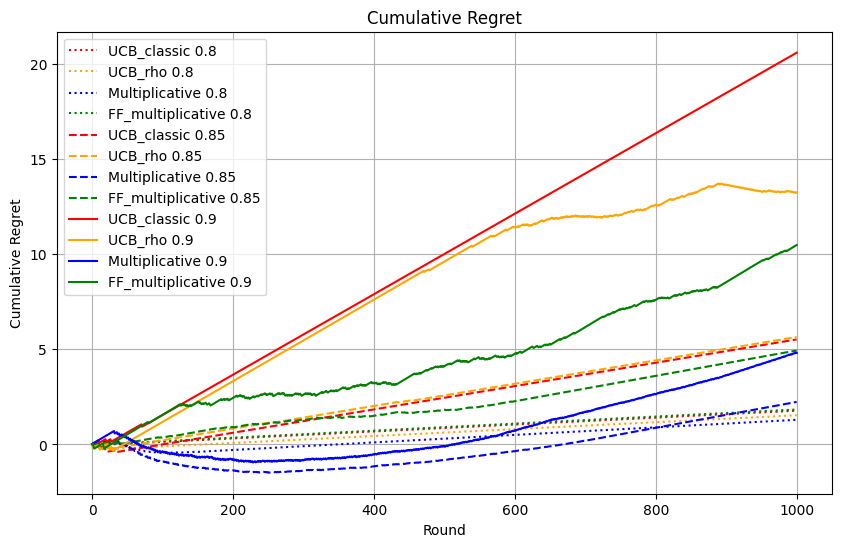

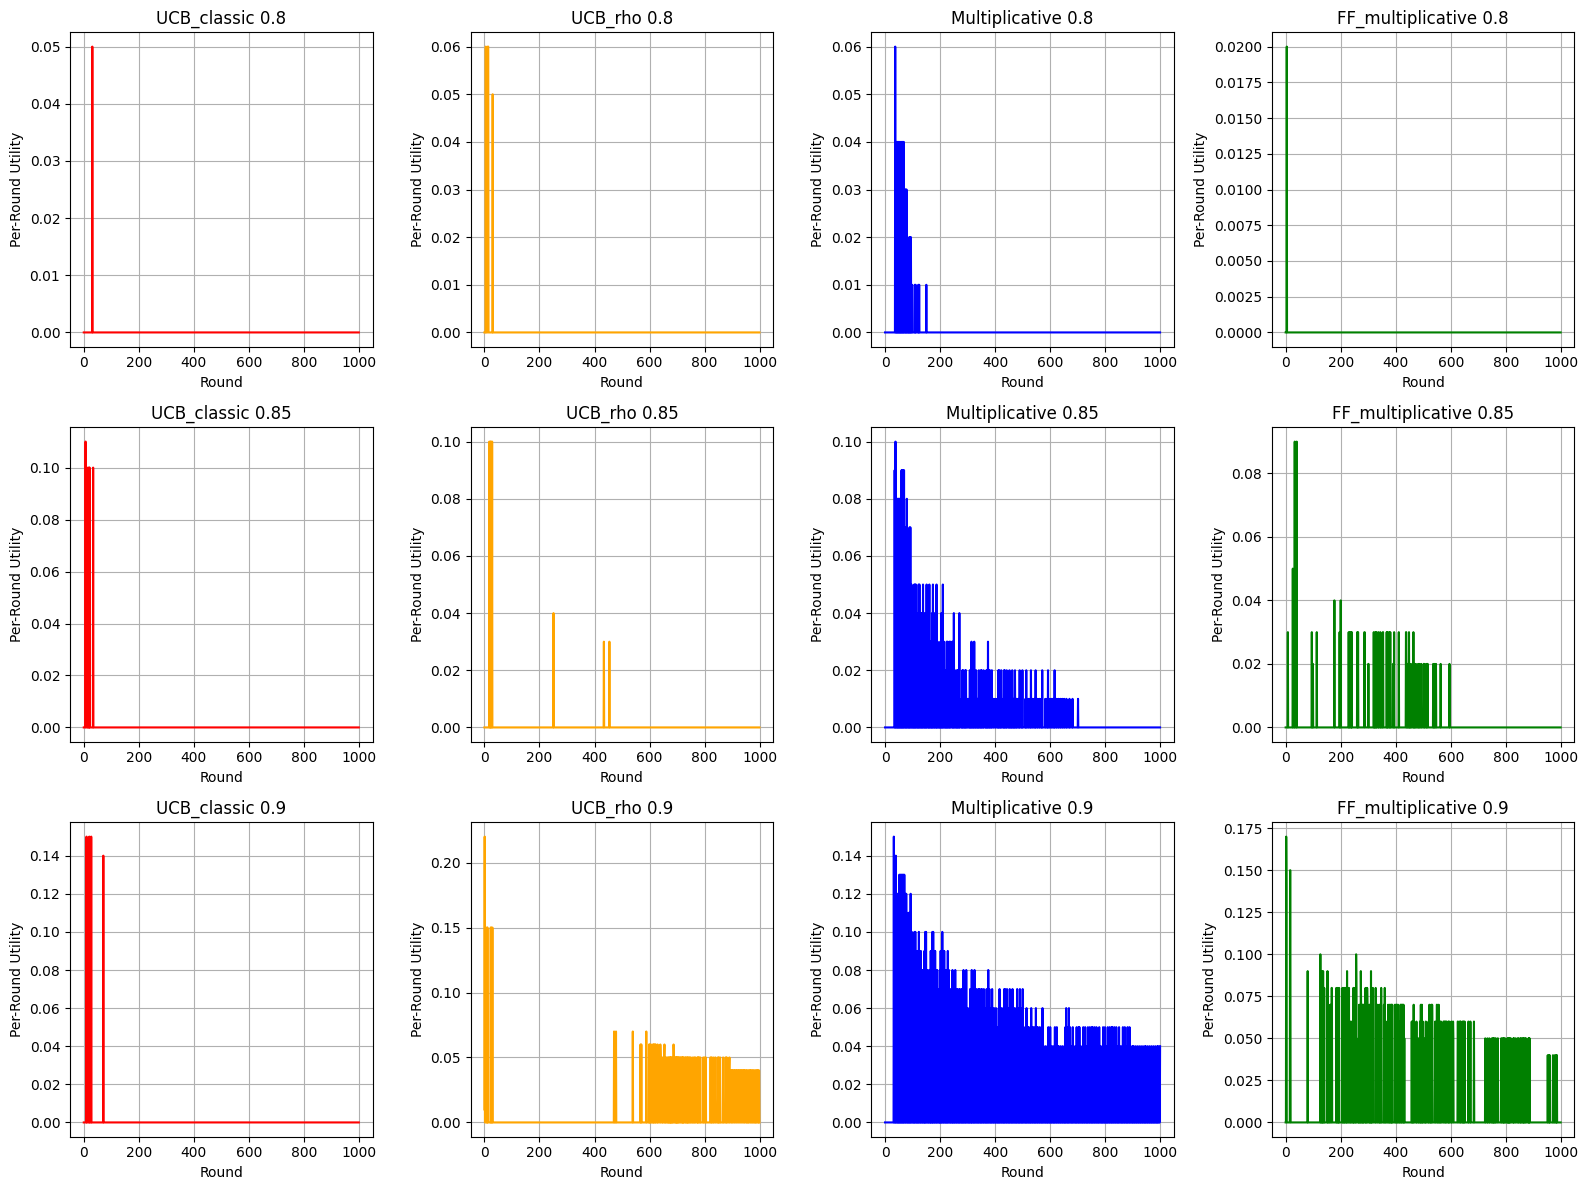

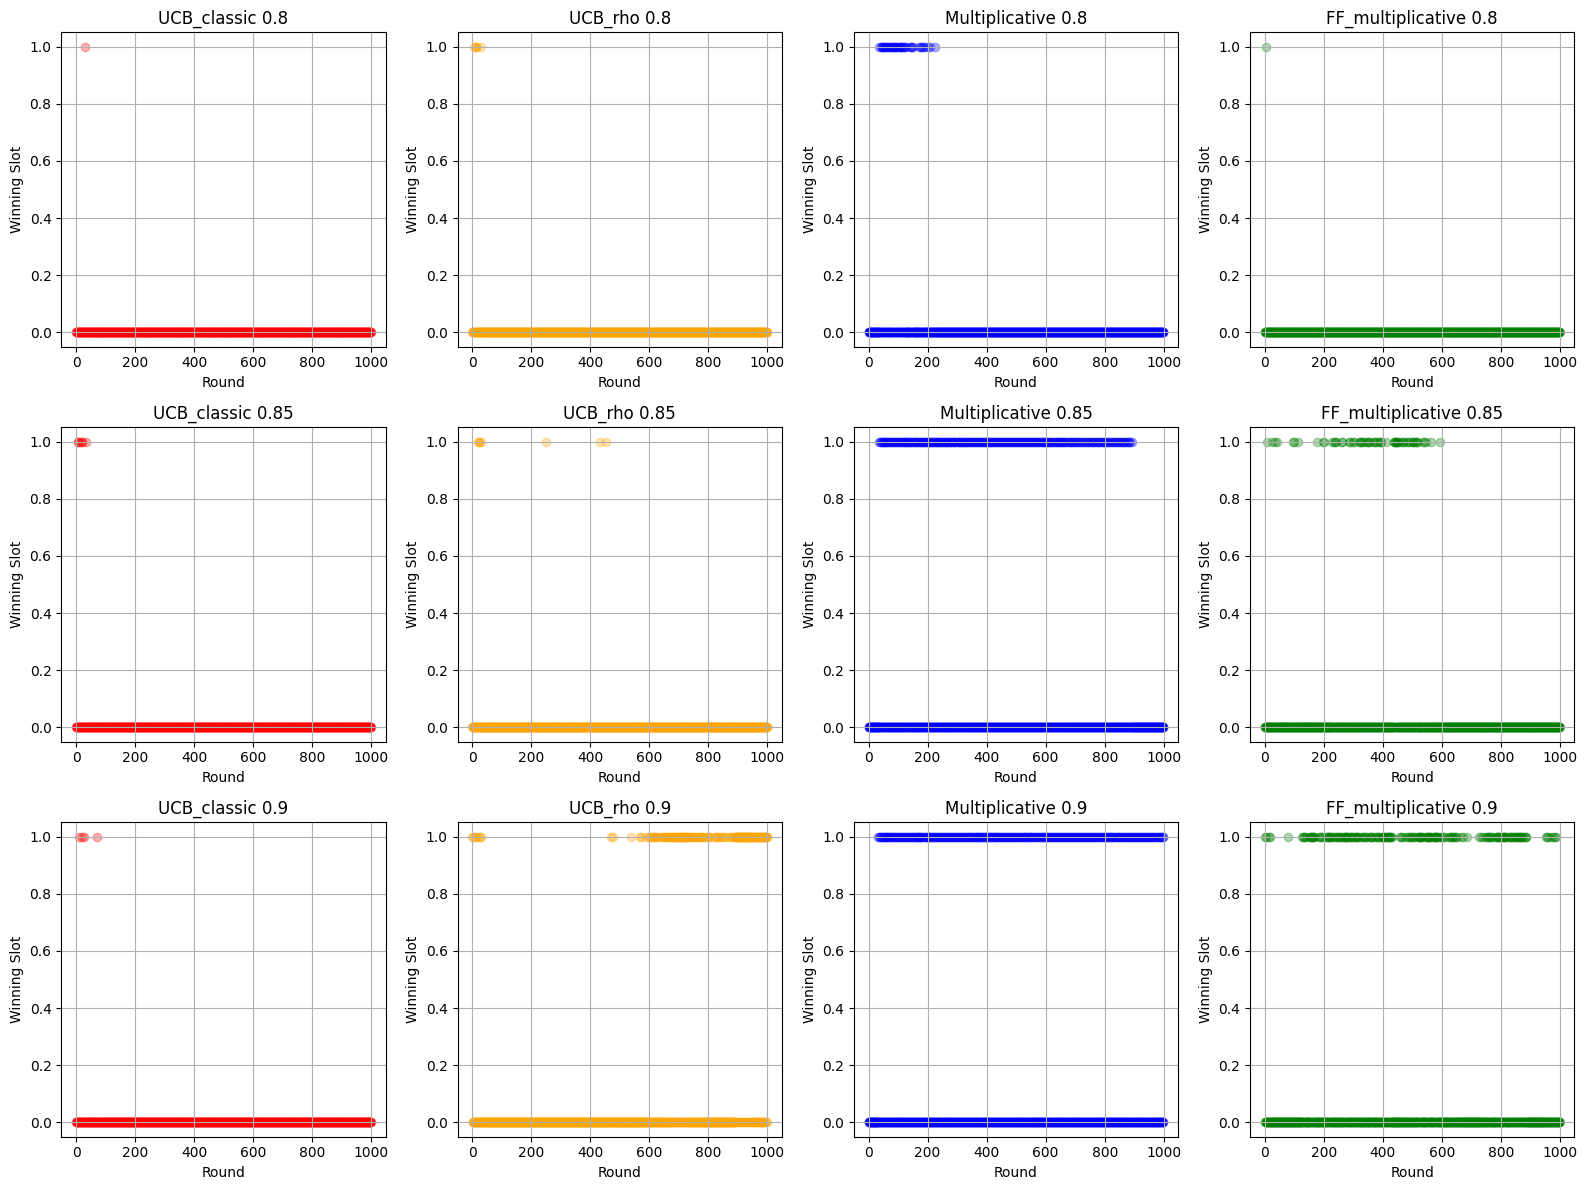

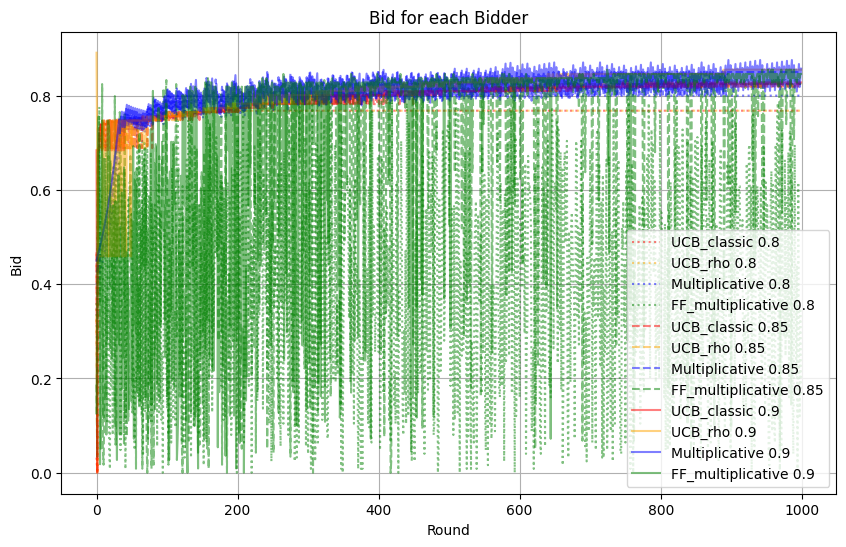

In [37]:
n_users = 1000
lambdas = [1]
valuations = [0.8, 0.85, 0.9]
rho = 0.25
budget = n_users * rho

problem_params = {"n_users" : n_users, "lambdas" : lambdas,
                 "budget" : budget, "valuations" : valuations,
                 "name_file" : "single_slots"}

random.seed(69)

req = Requirement4(problem_params)
req.run()